In [1]:
import tensorflow_io as tfio

In [2]:
import datetime

In [3]:
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from performance_evaluation import plot_training_history, evaluate_model_performance

from tensorflow.python.client import device_lib

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], enable=True
)

# Read in Data

In [5]:
train_data = h5py.File('data/online_and_order/order_history_train.h5', 'r')

In [6]:
train_X_orders = np.array(train_data.get('train_X_orders'))
train_X_order_month = np.array(train_data.get('train_X_order_month'))
train_X_sessions = np.array(train_data.get('train_X_sessions'))
train_Y_order = np.array(train_data.get('train_Y_order'))

In [7]:
train_data.close()

In [8]:
test_data = h5py.File('data/online_and_order/order_history_test.h5', 'r')

In [9]:
test_X_orders = np.array(test_data.get('test_X_orders'))
test_X_order_month = np.array(test_data.get('test_X_order_month'))
test_X_sessions = np.array(test_data.get('test_X_sessions'))
test_Y_order = np.array(test_data.get('test_Y_order'))

In [10]:
test_data.close()

#### Normalize for Faster Training

In [11]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

range_for_x_cols = np.amax(train_X_orders, axis=0) - np.amin(train_X_orders, axis=0)
range_for_x_cols[range_for_x_cols == 0] = 1

In [12]:
norm_train_x = train_X_orders/range_for_x_cols
norm_test_x = test_X_orders/range_for_x_cols

# Setup Model Architecture

In [13]:
order_history = keras.Input(
    shape=(train_X_orders.shape[1], train_X_orders.shape[2],), 
    name='Order_History'
)

In [14]:
order_month = keras.Input(
    shape=(train_X_order_month.shape[1],), 
    name='Order_Month'
)

In [15]:
session_history = keras.Input(
    shape=(test_X_sessions.shape[1], test_X_sessions.shape[2],), 
    name='Session_History'
)

In [16]:
dropout = .6

In [17]:
i=1

#### Set Order History Pipeline

In [18]:
ord_hist_x = layers.GRU(
    100, 
    name=f'ord_hist_GRU1',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout, 
    unroll = False,
    use_bias = True,
    return_sequences=True
)(order_history)

In [19]:
ord_hist_x = layers.GRU(
    100, 
    name=f'ord_hist_GRU2',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout,
    unroll = False,
    use_bias = True    
)(ord_hist_x)

In [20]:
ord_hist_x = keras.layers.Flatten()(ord_hist_x)

#### Session History

In [21]:
sess_hist_x = layers.GRU(
    100, 
    name=f'sess_hist_GRU1',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout, 
    unroll = False,
    use_bias = True,
    return_sequences=True
)(session_history)

In [22]:
sess_hist_x = layers.GRU(
    100, 
    name=f'sess_hist_GRU2',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout,
    unroll = False,
    use_bias = True    
)(sess_hist_x)

In [23]:
sess_hist_x = keras.layers.Flatten()(sess_hist_x)

In [24]:
concat_x = keras.layers.Concatenate(axis=1)([ord_hist_x, order_month, sess_hist_x])

In [25]:
x = layers.BatchNormalization()(concat_x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [26]:
# Adding another concatenation of order month to ensure the signal isn't lost due to dropout
x = keras.layers.Concatenate(axis=1)([x, order_month])

In [27]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [28]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [29]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [30]:
outputs = layers.Dense(6, activation='sigmoid')(x)

In [31]:
model = keras.Model(
    inputs=[order_history, order_month,session_history], 
    outputs=outputs, name="3_Channel_GRU_NN"
)

In [32]:
model.summary()

Model: "3_Channel_GRU_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Order_History (InputLayer)      [(None, 14, 253)]    0                                            
__________________________________________________________________________________________________
Session_History (InputLayer)    [(None, 53, 24)]     0                                            
__________________________________________________________________________________________________
ord_hist_GRU1 (GRU)             (None, 14, 100)      106500      Order_History[0][0]              
__________________________________________________________________________________________________
sess_hist_GRU1 (GRU)            (None, 53, 100)      37800       Session_History[0][0]            
___________________________________________________________________________________

In [33]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [36]:
# Remove Existing Logs in TensorBoard
!rm -r /home/ben/gitrepos/shfly/logs

In [37]:
history = model.fit(
    [train_X_orders, train_X_order_month, train_X_sessions],
    train_Y_order, batch_size=5000, epochs=7200, validation_split=0.2,
    callbacks=[tensorboard_callback]
)

Epoch 1/7200
 1/14 [=>............................] - ETA: 0s - loss: 2.3968 - accuracy: 0.1622WARNING:tensorflow:From /home/ben/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
14/14 [==============================] - 4s 288ms/step - loss: 2.2862 - accuracy: 0.2015 - val_loss: 1.8760 - val_accuracy: 0.1623
Epoch 2/7200
14/14 [==============================] - 3s 224ms/step - loss: 2.1396 - accuracy: 0.2812 - val_loss: 1.8638 - val_accuracy: 0.2265
Epoch 3/7200
14/14 [==============================] - 3s 218ms/step - loss: 2.0608 - accuracy: 0.3331 - val_loss: 1.8413 - val_accuracy: 0.2809
Epoch 4/7200
14/14 [==============================] - 3s 217ms/step - loss: 2.0302 - accuracy: 0.3595 - val_loss: 1.8310 - val_accuracy: 0.2984
Epoch 5/7200
14/14 [==============================] - 3

14/14 [==============================] - 3s 220ms/step - loss: 1.8865 - accuracy: 0.4283 - val_loss: 1.8833 - val_accuracy: 0.2782
Epoch 56/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8845 - accuracy: 0.4296 - val_loss: 1.8277 - val_accuracy: 0.2774
Epoch 57/7200
14/14 [==============================] - 3s 221ms/step - loss: 1.8853 - accuracy: 0.4319 - val_loss: 1.7545 - val_accuracy: 0.3025
Epoch 58/7200
14/14 [==============================] - 3s 218ms/step - loss: 1.8853 - accuracy: 0.4317 - val_loss: 1.7786 - val_accuracy: 0.3242
Epoch 59/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8819 - accuracy: 0.4309 - val_loss: 1.8046 - val_accuracy: 0.3046
Epoch 60/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8855 - accuracy: 0.4310 - val_loss: 1.8265 - val_accuracy: 0.2943
Epoch 61/7200
14/14 [==============================] - 3s 223ms/step - loss: 1.8852 - accuracy: 0.4308 - val_loss: 1.8454 - val_accuracy: 0.2947

14/14 [==============================] - 3s 216ms/step - loss: 1.8628 - accuracy: 0.4349 - val_loss: 1.7553 - val_accuracy: 0.3430
Epoch 112/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8615 - accuracy: 0.4353 - val_loss: 1.7106 - val_accuracy: 0.3619
Epoch 113/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8637 - accuracy: 0.4347 - val_loss: 1.7424 - val_accuracy: 0.3433
Epoch 114/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8632 - accuracy: 0.4333 - val_loss: 1.7865 - val_accuracy: 0.3194
Epoch 115/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8631 - accuracy: 0.4322 - val_loss: 1.8082 - val_accuracy: 0.3115
Epoch 116/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8586 - accuracy: 0.4361 - val_loss: 1.8469 - val_accuracy: 0.2936
Epoch 117/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8618 - accuracy: 0.4352 - val_loss: 1.7925 - val_accuracy: 

14/14 [==============================] - 3s 216ms/step - loss: 1.8463 - accuracy: 0.4409 - val_loss: 1.7379 - val_accuracy: 0.3197
Epoch 168/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8478 - accuracy: 0.4394 - val_loss: 1.7477 - val_accuracy: 0.3177
Epoch 169/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8451 - accuracy: 0.4405 - val_loss: 1.7729 - val_accuracy: 0.3127
Epoch 170/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8453 - accuracy: 0.4403 - val_loss: 1.7809 - val_accuracy: 0.3097
Epoch 171/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8473 - accuracy: 0.4415 - val_loss: 1.8002 - val_accuracy: 0.3052
Epoch 172/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8466 - accuracy: 0.4405 - val_loss: 1.7690 - val_accuracy: 0.3152
Epoch 173/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8456 - accuracy: 0.4425 - val_loss: 1.7756 - val_accuracy: 

14/14 [==============================] - 3s 215ms/step - loss: 1.8335 - accuracy: 0.4455 - val_loss: 1.7314 - val_accuracy: 0.3328
Epoch 224/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8368 - accuracy: 0.4422 - val_loss: 1.7647 - val_accuracy: 0.3139
Epoch 225/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8354 - accuracy: 0.4447 - val_loss: 1.7368 - val_accuracy: 0.3169
Epoch 226/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8371 - accuracy: 0.4436 - val_loss: 1.7282 - val_accuracy: 0.3242
Epoch 227/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8362 - accuracy: 0.4439 - val_loss: 1.6884 - val_accuracy: 0.3582
Epoch 228/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8337 - accuracy: 0.4447 - val_loss: 1.7098 - val_accuracy: 0.3329
Epoch 229/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8339 - accuracy: 0.4450 - val_loss: 1.6925 - val_accuracy: 

14/14 [==============================] - 3s 215ms/step - loss: 1.8252 - accuracy: 0.4485 - val_loss: 1.6931 - val_accuracy: 0.3444
Epoch 280/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8270 - accuracy: 0.4482 - val_loss: 1.7200 - val_accuracy: 0.3369
Epoch 281/7200
14/14 [==============================] - 3s 216ms/step - loss: 1.8244 - accuracy: 0.4475 - val_loss: 1.7393 - val_accuracy: 0.3170
Epoch 282/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8283 - accuracy: 0.4475 - val_loss: 1.7179 - val_accuracy: 0.3325
Epoch 283/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8283 - accuracy: 0.4468 - val_loss: 1.7522 - val_accuracy: 0.3246
Epoch 284/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8271 - accuracy: 0.4459 - val_loss: 1.6961 - val_accuracy: 0.3497
Epoch 285/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8263 - accuracy: 0.4475 - val_loss: 1.7440 - val_accuracy: 

14/14 [==============================] - 3s 215ms/step - loss: 1.8199 - accuracy: 0.4479 - val_loss: 1.7061 - val_accuracy: 0.3434
Epoch 336/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8206 - accuracy: 0.4497 - val_loss: 1.7148 - val_accuracy: 0.3409
Epoch 337/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8196 - accuracy: 0.4509 - val_loss: 1.7174 - val_accuracy: 0.3394
Epoch 338/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8194 - accuracy: 0.4488 - val_loss: 1.7295 - val_accuracy: 0.3397
Epoch 339/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8214 - accuracy: 0.4471 - val_loss: 1.7309 - val_accuracy: 0.3389
Epoch 340/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.8196 - accuracy: 0.4497 - val_loss: 1.7060 - val_accuracy: 0.3312
Epoch 341/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8232 - accuracy: 0.4476 - val_loss: 1.6983 - val_accuracy: 

14/14 [==============================] - 3s 214ms/step - loss: 1.8162 - accuracy: 0.4503 - val_loss: 1.7173 - val_accuracy: 0.3351
Epoch 392/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8171 - accuracy: 0.4499 - val_loss: 1.7514 - val_accuracy: 0.3231
Epoch 393/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8171 - accuracy: 0.4502 - val_loss: 1.7417 - val_accuracy: 0.3223
Epoch 394/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8175 - accuracy: 0.4503 - val_loss: 1.7486 - val_accuracy: 0.3289
Epoch 395/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8151 - accuracy: 0.4517 - val_loss: 1.7690 - val_accuracy: 0.3189
Epoch 396/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8160 - accuracy: 0.4490 - val_loss: 1.7320 - val_accuracy: 0.3339
Epoch 397/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8152 - accuracy: 0.4490 - val_loss: 1.8070 - val_accuracy: 

14/14 [==============================] - 3s 212ms/step - loss: 1.8092 - accuracy: 0.4527 - val_loss: 1.7610 - val_accuracy: 0.3202
Epoch 448/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8136 - accuracy: 0.4525 - val_loss: 1.7744 - val_accuracy: 0.3170
Epoch 449/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8114 - accuracy: 0.4527 - val_loss: 1.7368 - val_accuracy: 0.3335
Epoch 450/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8117 - accuracy: 0.4511 - val_loss: 1.7199 - val_accuracy: 0.3334
Epoch 451/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8114 - accuracy: 0.4522 - val_loss: 1.7230 - val_accuracy: 0.3333
Epoch 452/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8101 - accuracy: 0.4538 - val_loss: 1.7804 - val_accuracy: 0.3188
Epoch 453/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8106 - accuracy: 0.4523 - val_loss: 1.7627 - val_accuracy: 

14/14 [==============================] - 3s 214ms/step - loss: 1.8070 - accuracy: 0.4516 - val_loss: 1.6865 - val_accuracy: 0.3491
Epoch 504/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8066 - accuracy: 0.4539 - val_loss: 1.7263 - val_accuracy: 0.3355
Epoch 505/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8069 - accuracy: 0.4529 - val_loss: 1.7188 - val_accuracy: 0.3469
Epoch 506/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8074 - accuracy: 0.4519 - val_loss: 1.7097 - val_accuracy: 0.3474
Epoch 507/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.8100 - accuracy: 0.4527 - val_loss: 1.7304 - val_accuracy: 0.3336
Epoch 508/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8063 - accuracy: 0.4541 - val_loss: 1.7729 - val_accuracy: 0.3193
Epoch 509/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8057 - accuracy: 0.4509 - val_loss: 1.7359 - val_accuracy: 

14/14 [==============================] - 3s 214ms/step - loss: 1.8033 - accuracy: 0.4558 - val_loss: 1.7685 - val_accuracy: 0.3179
Epoch 560/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8046 - accuracy: 0.4533 - val_loss: 1.7254 - val_accuracy: 0.3311
Epoch 561/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8024 - accuracy: 0.4537 - val_loss: 1.7386 - val_accuracy: 0.3296
Epoch 562/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8057 - accuracy: 0.4519 - val_loss: 1.7837 - val_accuracy: 0.3062
Epoch 563/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8029 - accuracy: 0.4533 - val_loss: 1.7192 - val_accuracy: 0.3295
Epoch 564/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8040 - accuracy: 0.4532 - val_loss: 1.7158 - val_accuracy: 0.3379
Epoch 565/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8036 - accuracy: 0.4529 - val_loss: 1.6989 - val_accuracy: 

14/14 [==============================] - 3s 213ms/step - loss: 1.8027 - accuracy: 0.4549 - val_loss: 1.7629 - val_accuracy: 0.3221
Epoch 616/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8016 - accuracy: 0.4548 - val_loss: 1.7124 - val_accuracy: 0.3461
Epoch 617/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8005 - accuracy: 0.4540 - val_loss: 1.7637 - val_accuracy: 0.3292
Epoch 618/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.8016 - accuracy: 0.4554 - val_loss: 1.7190 - val_accuracy: 0.3358
Epoch 619/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7997 - accuracy: 0.4560 - val_loss: 1.7686 - val_accuracy: 0.3197
Epoch 620/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.8017 - accuracy: 0.4543 - val_loss: 1.7459 - val_accuracy: 0.3321
Epoch 621/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.8001 - accuracy: 0.4563 - val_loss: 1.7231 - val_accuracy: 

14/14 [==============================] - 3s 210ms/step - loss: 1.8015 - accuracy: 0.4558 - val_loss: 1.7752 - val_accuracy: 0.3184
Epoch 672/7200
14/14 [==============================] - 3s 209ms/step - loss: 1.7986 - accuracy: 0.4553 - val_loss: 1.7695 - val_accuracy: 0.3184
Epoch 673/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7964 - accuracy: 0.4569 - val_loss: 1.7213 - val_accuracy: 0.3248
Epoch 674/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7976 - accuracy: 0.4564 - val_loss: 1.7114 - val_accuracy: 0.3374
Epoch 675/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7973 - accuracy: 0.4574 - val_loss: 1.7162 - val_accuracy: 0.3348
Epoch 676/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7967 - accuracy: 0.4557 - val_loss: 1.7173 - val_accuracy: 0.3367
Epoch 677/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7964 - accuracy: 0.4583 - val_loss: 1.7292 - val_accuracy: 

14/14 [==============================] - 3s 213ms/step - loss: 1.7949 - accuracy: 0.4586 - val_loss: 1.7344 - val_accuracy: 0.3310
Epoch 728/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7945 - accuracy: 0.4592 - val_loss: 1.7490 - val_accuracy: 0.3325
Epoch 729/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7927 - accuracy: 0.4582 - val_loss: 1.7249 - val_accuracy: 0.3323
Epoch 730/7200
14/14 [==============================] - 3s 209ms/step - loss: 1.7968 - accuracy: 0.4567 - val_loss: 1.7623 - val_accuracy: 0.3171
Epoch 731/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7947 - accuracy: 0.4583 - val_loss: 1.7653 - val_accuracy: 0.3168
Epoch 732/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7951 - accuracy: 0.4578 - val_loss: 1.7430 - val_accuracy: 0.3293
Epoch 733/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7932 - accuracy: 0.4592 - val_loss: 1.7866 - val_accuracy: 

14/14 [==============================] - 3s 213ms/step - loss: 1.7940 - accuracy: 0.4576 - val_loss: 1.7440 - val_accuracy: 0.3296
Epoch 784/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7914 - accuracy: 0.4599 - val_loss: 1.7783 - val_accuracy: 0.3184
Epoch 785/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7912 - accuracy: 0.4595 - val_loss: 1.7259 - val_accuracy: 0.3240
Epoch 786/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7905 - accuracy: 0.4583 - val_loss: 1.7580 - val_accuracy: 0.3135
Epoch 787/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7931 - accuracy: 0.4572 - val_loss: 1.7735 - val_accuracy: 0.2977
Epoch 788/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7955 - accuracy: 0.4571 - val_loss: 1.7133 - val_accuracy: 0.3430
Epoch 789/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7923 - accuracy: 0.4573 - val_loss: 1.7545 - val_accuracy: 

14/14 [==============================] - 3s 213ms/step - loss: 1.7884 - accuracy: 0.4585 - val_loss: 1.8043 - val_accuracy: 0.3097
Epoch 840/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7904 - accuracy: 0.4577 - val_loss: 1.8080 - val_accuracy: 0.3175
Epoch 841/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7879 - accuracy: 0.4615 - val_loss: 1.7755 - val_accuracy: 0.3279
Epoch 842/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7891 - accuracy: 0.4605 - val_loss: 1.7523 - val_accuracy: 0.3232
Epoch 843/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7926 - accuracy: 0.4590 - val_loss: 1.7797 - val_accuracy: 0.3166
Epoch 844/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7913 - accuracy: 0.4582 - val_loss: 1.7862 - val_accuracy: 0.3115
Epoch 845/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7910 - accuracy: 0.4585 - val_loss: 1.7784 - val_accuracy: 

14/14 [==============================] - 3s 214ms/step - loss: 1.7869 - accuracy: 0.4584 - val_loss: 1.7289 - val_accuracy: 0.3348
Epoch 896/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7886 - accuracy: 0.4575 - val_loss: 1.8050 - val_accuracy: 0.3162
Epoch 897/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7876 - accuracy: 0.4609 - val_loss: 1.7171 - val_accuracy: 0.3378
Epoch 898/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7885 - accuracy: 0.4607 - val_loss: 1.7133 - val_accuracy: 0.3397
Epoch 899/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7869 - accuracy: 0.4598 - val_loss: 1.7197 - val_accuracy: 0.3393
Epoch 900/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7868 - accuracy: 0.4612 - val_loss: 1.7478 - val_accuracy: 0.3225
Epoch 901/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7886 - accuracy: 0.4592 - val_loss: 1.7462 - val_accuracy: 

14/14 [==============================] - 3s 213ms/step - loss: 1.7855 - accuracy: 0.4616 - val_loss: 1.7414 - val_accuracy: 0.3273
Epoch 952/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7833 - accuracy: 0.4605 - val_loss: 1.7911 - val_accuracy: 0.3083
Epoch 953/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7841 - accuracy: 0.4629 - val_loss: 1.7543 - val_accuracy: 0.3272
Epoch 954/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7866 - accuracy: 0.4605 - val_loss: 1.7418 - val_accuracy: 0.3252
Epoch 955/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7849 - accuracy: 0.4604 - val_loss: 1.7640 - val_accuracy: 0.3234
Epoch 956/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7828 - accuracy: 0.4622 - val_loss: 1.7381 - val_accuracy: 0.3288
Epoch 957/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7871 - accuracy: 0.4604 - val_loss: 1.7807 - val_accuracy: 

14/14 [==============================] - 3s 213ms/step - loss: 1.7808 - accuracy: 0.4634 - val_loss: 1.7451 - val_accuracy: 0.3277
Epoch 1008/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7836 - accuracy: 0.4616 - val_loss: 1.7383 - val_accuracy: 0.3259
Epoch 1009/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7840 - accuracy: 0.4608 - val_loss: 1.7605 - val_accuracy: 0.3262
Epoch 1010/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7831 - accuracy: 0.4638 - val_loss: 1.7643 - val_accuracy: 0.3240
Epoch 1011/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7835 - accuracy: 0.4613 - val_loss: 1.7695 - val_accuracy: 0.3223
Epoch 1012/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7834 - accuracy: 0.4598 - val_loss: 1.7261 - val_accuracy: 0.3365
Epoch 1013/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7835 - accuracy: 0.4630 - val_loss: 1.7658 - val_accu

Epoch 1063/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7795 - accuracy: 0.4634 - val_loss: 1.7566 - val_accuracy: 0.3259
Epoch 1064/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7826 - accuracy: 0.4621 - val_loss: 1.7755 - val_accuracy: 0.3191
Epoch 1065/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7808 - accuracy: 0.4643 - val_loss: 1.8115 - val_accuracy: 0.3088
Epoch 1066/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7795 - accuracy: 0.4641 - val_loss: 1.8081 - val_accuracy: 0.2851
Epoch 1067/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7826 - accuracy: 0.4612 - val_loss: 1.8035 - val_accuracy: 0.3152
Epoch 1068/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7837 - accuracy: 0.4597 - val_loss: 1.7878 - val_accuracy: 0.3148
Epoch 1069/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7827 - accuracy: 0.4629 - val_loss: 1

Epoch 1119/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7807 - accuracy: 0.4615 - val_loss: 1.8135 - val_accuracy: 0.3083
Epoch 1120/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7790 - accuracy: 0.4642 - val_loss: 1.8035 - val_accuracy: 0.3092
Epoch 1121/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7805 - accuracy: 0.4619 - val_loss: 1.7921 - val_accuracy: 0.3107
Epoch 1122/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7780 - accuracy: 0.4638 - val_loss: 1.8022 - val_accuracy: 0.3108
Epoch 1123/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7765 - accuracy: 0.4644 - val_loss: 1.7848 - val_accuracy: 0.3158
Epoch 1124/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7777 - accuracy: 0.4635 - val_loss: 1.7753 - val_accuracy: 0.3196
Epoch 1125/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7788 - accuracy: 0.4637 - val_loss: 1

Epoch 1175/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7761 - accuracy: 0.4641 - val_loss: 1.8068 - val_accuracy: 0.3182
Epoch 1176/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7780 - accuracy: 0.4659 - val_loss: 1.8105 - val_accuracy: 0.3128
Epoch 1177/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7777 - accuracy: 0.4649 - val_loss: 1.7674 - val_accuracy: 0.3188
Epoch 1178/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7771 - accuracy: 0.4629 - val_loss: 1.7644 - val_accuracy: 0.3230
Epoch 1179/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7776 - accuracy: 0.4626 - val_loss: 1.7810 - val_accuracy: 0.3189
Epoch 1180/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7764 - accuracy: 0.4649 - val_loss: 1.8083 - val_accuracy: 0.3106
Epoch 1181/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7766 - accuracy: 0.4646 - val_loss: 1

Epoch 1231/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7756 - accuracy: 0.4650 - val_loss: 1.7910 - val_accuracy: 0.3147
Epoch 1232/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7752 - accuracy: 0.4656 - val_loss: 1.7708 - val_accuracy: 0.3239
Epoch 1233/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7747 - accuracy: 0.4647 - val_loss: 1.8091 - val_accuracy: 0.3144
Epoch 1234/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7763 - accuracy: 0.4647 - val_loss: 1.8009 - val_accuracy: 0.3162
Epoch 1235/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7784 - accuracy: 0.4645 - val_loss: 1.8156 - val_accuracy: 0.3101
Epoch 1236/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7766 - accuracy: 0.4642 - val_loss: 1.7644 - val_accuracy: 0.3262
Epoch 1237/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7757 - accuracy: 0.4633 - val_loss: 1

Epoch 1287/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7732 - accuracy: 0.4641 - val_loss: 1.7924 - val_accuracy: 0.3204
Epoch 1288/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7738 - accuracy: 0.4645 - val_loss: 1.7882 - val_accuracy: 0.3201
Epoch 1289/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7745 - accuracy: 0.4641 - val_loss: 1.8159 - val_accuracy: 0.3156
Epoch 1290/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7748 - accuracy: 0.4643 - val_loss: 1.7946 - val_accuracy: 0.3205
Epoch 1291/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7739 - accuracy: 0.4644 - val_loss: 1.7555 - val_accuracy: 0.3266
Epoch 1292/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7731 - accuracy: 0.4650 - val_loss: 1.7532 - val_accuracy: 0.3281
Epoch 1293/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7737 - accuracy: 0.4654 - val_loss: 1

Epoch 1343/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7738 - accuracy: 0.4651 - val_loss: 1.7883 - val_accuracy: 0.3213
Epoch 1344/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7710 - accuracy: 0.4662 - val_loss: 1.7854 - val_accuracy: 0.3132
Epoch 1345/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7729 - accuracy: 0.4641 - val_loss: 1.7675 - val_accuracy: 0.3198
Epoch 1346/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7713 - accuracy: 0.4651 - val_loss: 1.8054 - val_accuracy: 0.3159
Epoch 1347/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7719 - accuracy: 0.4644 - val_loss: 1.7798 - val_accuracy: 0.3239
Epoch 1348/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7716 - accuracy: 0.4680 - val_loss: 1.7909 - val_accuracy: 0.3162
Epoch 1349/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7733 - accuracy: 0.4656 - val_loss: 1

Epoch 1399/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7699 - accuracy: 0.4678 - val_loss: 1.7921 - val_accuracy: 0.3197
Epoch 1400/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7705 - accuracy: 0.4670 - val_loss: 1.7748 - val_accuracy: 0.3230
Epoch 1401/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7678 - accuracy: 0.4698 - val_loss: 1.7582 - val_accuracy: 0.3304
Epoch 1402/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7689 - accuracy: 0.4683 - val_loss: 1.8056 - val_accuracy: 0.3085
Epoch 1403/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7699 - accuracy: 0.4685 - val_loss: 1.7889 - val_accuracy: 0.3250
Epoch 1404/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7705 - accuracy: 0.4680 - val_loss: 1.7685 - val_accuracy: 0.3260
Epoch 1405/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7694 - accuracy: 0.4687 - val_loss: 1

Epoch 1455/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7680 - accuracy: 0.4665 - val_loss: 1.7501 - val_accuracy: 0.3331
Epoch 1456/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7702 - accuracy: 0.4666 - val_loss: 1.7989 - val_accuracy: 0.3188
Epoch 1457/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7685 - accuracy: 0.4662 - val_loss: 1.7802 - val_accuracy: 0.3186
Epoch 1458/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7671 - accuracy: 0.4699 - val_loss: 1.7717 - val_accuracy: 0.3261
Epoch 1459/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7646 - accuracy: 0.4681 - val_loss: 1.7991 - val_accuracy: 0.3113
Epoch 1460/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7700 - accuracy: 0.4673 - val_loss: 1.8078 - val_accuracy: 0.3167
Epoch 1461/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7683 - accuracy: 0.4664 - val_loss: 1

Epoch 1511/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7692 - accuracy: 0.4661 - val_loss: 1.7997 - val_accuracy: 0.3147
Epoch 1512/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7708 - accuracy: 0.4676 - val_loss: 1.8079 - val_accuracy: 0.3111
Epoch 1513/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7679 - accuracy: 0.4688 - val_loss: 1.7811 - val_accuracy: 0.3228
Epoch 1514/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7676 - accuracy: 0.4677 - val_loss: 1.8227 - val_accuracy: 0.3057
Epoch 1515/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7698 - accuracy: 0.4669 - val_loss: 1.7641 - val_accuracy: 0.3282
Epoch 1516/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7678 - accuracy: 0.4685 - val_loss: 1.7985 - val_accuracy: 0.3169
Epoch 1517/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7675 - accuracy: 0.4670 - val_loss: 1

Epoch 1567/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7652 - accuracy: 0.4689 - val_loss: 1.7591 - val_accuracy: 0.3303
Epoch 1568/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7643 - accuracy: 0.4696 - val_loss: 1.7993 - val_accuracy: 0.3208
Epoch 1569/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7656 - accuracy: 0.4682 - val_loss: 1.8278 - val_accuracy: 0.3082
Epoch 1570/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7663 - accuracy: 0.4698 - val_loss: 1.7910 - val_accuracy: 0.3211
Epoch 1571/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7658 - accuracy: 0.4683 - val_loss: 1.8297 - val_accuracy: 0.3153
Epoch 1572/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7674 - accuracy: 0.4681 - val_loss: 1.7942 - val_accuracy: 0.3256
Epoch 1573/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7636 - accuracy: 0.4694 - val_loss: 1

Epoch 1623/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7629 - accuracy: 0.4720 - val_loss: 1.8190 - val_accuracy: 0.3189
Epoch 1624/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7629 - accuracy: 0.4701 - val_loss: 1.7900 - val_accuracy: 0.3251
Epoch 1625/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7637 - accuracy: 0.4699 - val_loss: 1.8027 - val_accuracy: 0.3198
Epoch 1626/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7652 - accuracy: 0.4692 - val_loss: 1.8401 - val_accuracy: 0.3104
Epoch 1627/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7620 - accuracy: 0.4719 - val_loss: 1.8306 - val_accuracy: 0.3109
Epoch 1628/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7638 - accuracy: 0.4704 - val_loss: 1.8361 - val_accuracy: 0.3161
Epoch 1629/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7643 - accuracy: 0.4684 - val_loss: 1

Epoch 1679/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7653 - accuracy: 0.4694 - val_loss: 1.7728 - val_accuracy: 0.3362
Epoch 1680/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7657 - accuracy: 0.4709 - val_loss: 1.8086 - val_accuracy: 0.3212
Epoch 1681/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7631 - accuracy: 0.4724 - val_loss: 1.8008 - val_accuracy: 0.3194
Epoch 1682/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7641 - accuracy: 0.4671 - val_loss: 1.7604 - val_accuracy: 0.3271
Epoch 1683/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7608 - accuracy: 0.4695 - val_loss: 1.7970 - val_accuracy: 0.3186
Epoch 1684/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7623 - accuracy: 0.4680 - val_loss: 1.7868 - val_accuracy: 0.3231
Epoch 1685/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7636 - accuracy: 0.4699 - val_loss: 1

Epoch 1735/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7598 - accuracy: 0.4697 - val_loss: 1.7829 - val_accuracy: 0.3324
Epoch 1736/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7615 - accuracy: 0.4690 - val_loss: 1.7808 - val_accuracy: 0.3248
Epoch 1737/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7597 - accuracy: 0.4715 - val_loss: 1.7821 - val_accuracy: 0.3335
Epoch 1738/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7642 - accuracy: 0.4705 - val_loss: 1.7740 - val_accuracy: 0.3261
Epoch 1739/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7610 - accuracy: 0.4682 - val_loss: 1.7908 - val_accuracy: 0.3242
Epoch 1740/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7610 - accuracy: 0.4699 - val_loss: 1.7506 - val_accuracy: 0.3412
Epoch 1741/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7616 - accuracy: 0.4737 - val_loss: 1

Epoch 1791/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7599 - accuracy: 0.4708 - val_loss: 1.8007 - val_accuracy: 0.3205
Epoch 1792/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7603 - accuracy: 0.4699 - val_loss: 1.7977 - val_accuracy: 0.3247
Epoch 1793/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7593 - accuracy: 0.4709 - val_loss: 1.8182 - val_accuracy: 0.3177
Epoch 1794/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7622 - accuracy: 0.4701 - val_loss: 1.8267 - val_accuracy: 0.3166
Epoch 1795/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7597 - accuracy: 0.4705 - val_loss: 1.7621 - val_accuracy: 0.3330
Epoch 1796/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7599 - accuracy: 0.4707 - val_loss: 1.8360 - val_accuracy: 0.3119
Epoch 1797/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7610 - accuracy: 0.4703 - val_loss: 1

Epoch 1847/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7610 - accuracy: 0.4709 - val_loss: 1.7920 - val_accuracy: 0.3231
Epoch 1848/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7580 - accuracy: 0.4723 - val_loss: 1.8135 - val_accuracy: 0.3126
Epoch 1849/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7599 - accuracy: 0.4703 - val_loss: 1.8106 - val_accuracy: 0.3171
Epoch 1850/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7567 - accuracy: 0.4714 - val_loss: 1.8023 - val_accuracy: 0.3204
Epoch 1851/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7595 - accuracy: 0.4718 - val_loss: 1.8168 - val_accuracy: 0.3206
Epoch 1852/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7604 - accuracy: 0.4711 - val_loss: 1.7754 - val_accuracy: 0.3210
Epoch 1853/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7572 - accuracy: 0.4714 - val_loss: 1

Epoch 1903/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7570 - accuracy: 0.4717 - val_loss: 1.7820 - val_accuracy: 0.3287
Epoch 1904/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7593 - accuracy: 0.4723 - val_loss: 1.7978 - val_accuracy: 0.3246
Epoch 1905/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7605 - accuracy: 0.4717 - val_loss: 1.7812 - val_accuracy: 0.3285
Epoch 1906/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7582 - accuracy: 0.4689 - val_loss: 1.7500 - val_accuracy: 0.3366
Epoch 1907/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7593 - accuracy: 0.4701 - val_loss: 1.7786 - val_accuracy: 0.3284
Epoch 1908/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7598 - accuracy: 0.4686 - val_loss: 1.8025 - val_accuracy: 0.3196
Epoch 1909/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7567 - accuracy: 0.4710 - val_loss: 1

Epoch 1959/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7571 - accuracy: 0.4727 - val_loss: 1.7741 - val_accuracy: 0.3279
Epoch 1960/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7556 - accuracy: 0.4697 - val_loss: 1.7817 - val_accuracy: 0.3310
Epoch 1961/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7577 - accuracy: 0.4733 - val_loss: 1.8056 - val_accuracy: 0.3155
Epoch 1962/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7587 - accuracy: 0.4715 - val_loss: 1.7836 - val_accuracy: 0.3232
Epoch 1963/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7580 - accuracy: 0.4708 - val_loss: 1.8231 - val_accuracy: 0.3144
Epoch 1964/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7588 - accuracy: 0.4711 - val_loss: 1.7649 - val_accuracy: 0.3281
Epoch 1965/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7567 - accuracy: 0.4698 - val_loss: 1

Epoch 2015/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7549 - accuracy: 0.4710 - val_loss: 1.8099 - val_accuracy: 0.3193
Epoch 2016/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7562 - accuracy: 0.4700 - val_loss: 1.7974 - val_accuracy: 0.3322
Epoch 2017/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7547 - accuracy: 0.4691 - val_loss: 1.7944 - val_accuracy: 0.3238
Epoch 2018/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7542 - accuracy: 0.4734 - val_loss: 1.8192 - val_accuracy: 0.3153
Epoch 2019/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7562 - accuracy: 0.4705 - val_loss: 1.7895 - val_accuracy: 0.3284
Epoch 2020/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7574 - accuracy: 0.4712 - val_loss: 1.7888 - val_accuracy: 0.3328
Epoch 2021/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7542 - accuracy: 0.4723 - val_loss: 1

Epoch 2071/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7542 - accuracy: 0.4746 - val_loss: 1.8014 - val_accuracy: 0.3225
Epoch 2072/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7521 - accuracy: 0.4746 - val_loss: 1.7871 - val_accuracy: 0.3238
Epoch 2073/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7546 - accuracy: 0.4718 - val_loss: 1.8462 - val_accuracy: 0.3140
Epoch 2074/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7527 - accuracy: 0.4733 - val_loss: 1.8164 - val_accuracy: 0.3172
Epoch 2075/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7512 - accuracy: 0.4755 - val_loss: 1.7822 - val_accuracy: 0.3258
Epoch 2076/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7543 - accuracy: 0.4726 - val_loss: 1.8027 - val_accuracy: 0.3082
Epoch 2077/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7554 - accuracy: 0.4726 - val_loss: 1

Epoch 2127/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7549 - accuracy: 0.4738 - val_loss: 1.7527 - val_accuracy: 0.3365
Epoch 2128/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7529 - accuracy: 0.4744 - val_loss: 1.8457 - val_accuracy: 0.3178
Epoch 2129/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7542 - accuracy: 0.4740 - val_loss: 1.8147 - val_accuracy: 0.3153
Epoch 2130/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7557 - accuracy: 0.4717 - val_loss: 1.7497 - val_accuracy: 0.3369
Epoch 2131/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7530 - accuracy: 0.4736 - val_loss: 1.7764 - val_accuracy: 0.3267
Epoch 2132/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7529 - accuracy: 0.4717 - val_loss: 1.7768 - val_accuracy: 0.3262
Epoch 2133/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7531 - accuracy: 0.4739 - val_loss: 1

Epoch 2183/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7525 - accuracy: 0.4712 - val_loss: 1.7935 - val_accuracy: 0.3221
Epoch 2184/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7518 - accuracy: 0.4713 - val_loss: 1.8245 - val_accuracy: 0.3177
Epoch 2185/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7517 - accuracy: 0.4740 - val_loss: 1.8082 - val_accuracy: 0.3192
Epoch 2186/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7521 - accuracy: 0.4733 - val_loss: 1.8352 - val_accuracy: 0.3140
Epoch 2187/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7526 - accuracy: 0.4756 - val_loss: 1.8124 - val_accuracy: 0.3222
Epoch 2188/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7530 - accuracy: 0.4727 - val_loss: 1.8209 - val_accuracy: 0.3145
Epoch 2189/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7505 - accuracy: 0.4743 - val_loss: 1

Epoch 2239/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7538 - accuracy: 0.4726 - val_loss: 1.7636 - val_accuracy: 0.3331
Epoch 2240/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7514 - accuracy: 0.4750 - val_loss: 1.7570 - val_accuracy: 0.3320
Epoch 2241/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7494 - accuracy: 0.4739 - val_loss: 1.8060 - val_accuracy: 0.3208
Epoch 2242/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7493 - accuracy: 0.4740 - val_loss: 1.7884 - val_accuracy: 0.3252
Epoch 2243/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7532 - accuracy: 0.4724 - val_loss: 1.7800 - val_accuracy: 0.3234
Epoch 2244/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7506 - accuracy: 0.4749 - val_loss: 1.7869 - val_accuracy: 0.3261
Epoch 2245/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7552 - accuracy: 0.4713 - val_loss: 1

Epoch 2295/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7495 - accuracy: 0.4738 - val_loss: 1.8620 - val_accuracy: 0.3065
Epoch 2296/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7510 - accuracy: 0.4756 - val_loss: 1.8255 - val_accuracy: 0.3140
Epoch 2297/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7498 - accuracy: 0.4757 - val_loss: 1.8214 - val_accuracy: 0.3175
Epoch 2298/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7498 - accuracy: 0.4756 - val_loss: 1.8075 - val_accuracy: 0.3240
Epoch 2299/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7481 - accuracy: 0.4747 - val_loss: 1.7852 - val_accuracy: 0.3309
Epoch 2300/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7515 - accuracy: 0.4753 - val_loss: 1.8179 - val_accuracy: 0.3181
Epoch 2301/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7490 - accuracy: 0.4760 - val_loss: 1

Epoch 2351/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7487 - accuracy: 0.4742 - val_loss: 1.8223 - val_accuracy: 0.3185
Epoch 2352/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7491 - accuracy: 0.4724 - val_loss: 1.7989 - val_accuracy: 0.3298
Epoch 2353/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7511 - accuracy: 0.4733 - val_loss: 1.8383 - val_accuracy: 0.3132
Epoch 2354/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7498 - accuracy: 0.4755 - val_loss: 1.8637 - val_accuracy: 0.3112
Epoch 2355/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7506 - accuracy: 0.4739 - val_loss: 1.8003 - val_accuracy: 0.3195
Epoch 2356/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7517 - accuracy: 0.4735 - val_loss: 1.8216 - val_accuracy: 0.3151
Epoch 2357/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7450 - accuracy: 0.4755 - val_loss: 1

Epoch 2407/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7495 - accuracy: 0.4751 - val_loss: 1.8142 - val_accuracy: 0.3154
Epoch 2408/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7472 - accuracy: 0.4758 - val_loss: 1.8315 - val_accuracy: 0.3162
Epoch 2409/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7493 - accuracy: 0.4743 - val_loss: 1.8052 - val_accuracy: 0.3248
Epoch 2410/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7484 - accuracy: 0.4741 - val_loss: 1.8486 - val_accuracy: 0.3175
Epoch 2411/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7453 - accuracy: 0.4753 - val_loss: 1.8040 - val_accuracy: 0.3289
Epoch 2412/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7499 - accuracy: 0.4750 - val_loss: 1.8196 - val_accuracy: 0.3238
Epoch 2413/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7494 - accuracy: 0.4733 - val_loss: 1

Epoch 2463/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7488 - accuracy: 0.4767 - val_loss: 1.8298 - val_accuracy: 0.3177
Epoch 2464/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7474 - accuracy: 0.4745 - val_loss: 1.7876 - val_accuracy: 0.3248
Epoch 2465/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7488 - accuracy: 0.4731 - val_loss: 1.7920 - val_accuracy: 0.3282
Epoch 2466/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7450 - accuracy: 0.4761 - val_loss: 1.8252 - val_accuracy: 0.3231
Epoch 2467/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7462 - accuracy: 0.4749 - val_loss: 1.8212 - val_accuracy: 0.3213
Epoch 2468/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7493 - accuracy: 0.4742 - val_loss: 1.7876 - val_accuracy: 0.3250
Epoch 2469/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7502 - accuracy: 0.4723 - val_loss: 1

Epoch 2519/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7462 - accuracy: 0.4772 - val_loss: 1.8072 - val_accuracy: 0.3178
Epoch 2520/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7483 - accuracy: 0.4732 - val_loss: 1.8343 - val_accuracy: 0.3112
Epoch 2521/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7474 - accuracy: 0.4759 - val_loss: 1.8178 - val_accuracy: 0.3172
Epoch 2522/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7459 - accuracy: 0.4768 - val_loss: 1.7936 - val_accuracy: 0.3280
Epoch 2523/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7473 - accuracy: 0.4737 - val_loss: 1.8053 - val_accuracy: 0.3262
Epoch 2524/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7483 - accuracy: 0.4740 - val_loss: 1.7988 - val_accuracy: 0.3232
Epoch 2525/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7449 - accuracy: 0.4758 - val_loss: 1

Epoch 2575/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7481 - accuracy: 0.4759 - val_loss: 1.8049 - val_accuracy: 0.3234
Epoch 2576/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7459 - accuracy: 0.4752 - val_loss: 1.7815 - val_accuracy: 0.3310
Epoch 2577/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7453 - accuracy: 0.4755 - val_loss: 1.7805 - val_accuracy: 0.3297
Epoch 2578/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7457 - accuracy: 0.4746 - val_loss: 1.8060 - val_accuracy: 0.3238
Epoch 2579/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7444 - accuracy: 0.4743 - val_loss: 1.7846 - val_accuracy: 0.3313
Epoch 2580/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7479 - accuracy: 0.4768 - val_loss: 1.7974 - val_accuracy: 0.3235
Epoch 2581/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7468 - accuracy: 0.4767 - val_loss: 1

Epoch 2631/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7466 - accuracy: 0.4764 - val_loss: 1.8097 - val_accuracy: 0.3209
Epoch 2632/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7458 - accuracy: 0.4744 - val_loss: 1.7977 - val_accuracy: 0.3256
Epoch 2633/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7436 - accuracy: 0.4763 - val_loss: 1.8260 - val_accuracy: 0.3175
Epoch 2634/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7479 - accuracy: 0.4746 - val_loss: 1.8186 - val_accuracy: 0.3154
Epoch 2635/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7459 - accuracy: 0.4775 - val_loss: 1.8669 - val_accuracy: 0.3037
Epoch 2636/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7464 - accuracy: 0.4758 - val_loss: 1.8444 - val_accuracy: 0.3100
Epoch 2637/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7479 - accuracy: 0.4749 - val_loss: 1

Epoch 2687/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7398 - accuracy: 0.4775 - val_loss: 1.8165 - val_accuracy: 0.3183
Epoch 2688/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7439 - accuracy: 0.4779 - val_loss: 1.8147 - val_accuracy: 0.3262
Epoch 2689/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7434 - accuracy: 0.4758 - val_loss: 1.8483 - val_accuracy: 0.3192
Epoch 2690/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7458 - accuracy: 0.4743 - val_loss: 1.8059 - val_accuracy: 0.3218
Epoch 2691/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7465 - accuracy: 0.4754 - val_loss: 1.7851 - val_accuracy: 0.3267
Epoch 2692/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7461 - accuracy: 0.4768 - val_loss: 1.7780 - val_accuracy: 0.3269
Epoch 2693/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7445 - accuracy: 0.4761 - val_loss: 1

Epoch 2743/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7439 - accuracy: 0.4763 - val_loss: 1.8463 - val_accuracy: 0.3139
Epoch 2744/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7424 - accuracy: 0.4781 - val_loss: 1.8346 - val_accuracy: 0.3167
Epoch 2745/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7410 - accuracy: 0.4773 - val_loss: 1.8570 - val_accuracy: 0.3160
Epoch 2746/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7459 - accuracy: 0.4767 - val_loss: 1.8210 - val_accuracy: 0.3181
Epoch 2747/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7448 - accuracy: 0.4757 - val_loss: 1.8218 - val_accuracy: 0.3225
Epoch 2748/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7434 - accuracy: 0.4778 - val_loss: 1.7977 - val_accuracy: 0.3240
Epoch 2749/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7462 - accuracy: 0.4751 - val_loss: 1

Epoch 2799/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7444 - accuracy: 0.4762 - val_loss: 1.7820 - val_accuracy: 0.3278
Epoch 2800/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7428 - accuracy: 0.4782 - val_loss: 1.8044 - val_accuracy: 0.3256
Epoch 2801/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7441 - accuracy: 0.4758 - val_loss: 1.8252 - val_accuracy: 0.3181
Epoch 2802/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7427 - accuracy: 0.4766 - val_loss: 1.8695 - val_accuracy: 0.3141
Epoch 2803/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7427 - accuracy: 0.4775 - val_loss: 1.8237 - val_accuracy: 0.3167
Epoch 2804/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7406 - accuracy: 0.4781 - val_loss: 1.8085 - val_accuracy: 0.3225
Epoch 2805/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7410 - accuracy: 0.4779 - val_loss: 1

Epoch 2855/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7409 - accuracy: 0.4769 - val_loss: 1.8001 - val_accuracy: 0.3200
Epoch 2856/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7404 - accuracy: 0.4796 - val_loss: 1.7984 - val_accuracy: 0.3225
Epoch 2857/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7414 - accuracy: 0.4775 - val_loss: 1.8168 - val_accuracy: 0.3141
Epoch 2858/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7427 - accuracy: 0.4773 - val_loss: 1.8203 - val_accuracy: 0.3179
Epoch 2859/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7446 - accuracy: 0.4783 - val_loss: 1.8115 - val_accuracy: 0.3183
Epoch 2860/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7422 - accuracy: 0.4779 - val_loss: 1.8016 - val_accuracy: 0.3287
Epoch 2861/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7400 - accuracy: 0.4778 - val_loss: 1

Epoch 2911/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7416 - accuracy: 0.4795 - val_loss: 1.8321 - val_accuracy: 0.3196
Epoch 2912/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7404 - accuracy: 0.4765 - val_loss: 1.8614 - val_accuracy: 0.3131
Epoch 2913/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7387 - accuracy: 0.4790 - val_loss: 1.8211 - val_accuracy: 0.3195
Epoch 2914/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7408 - accuracy: 0.4787 - val_loss: 1.8210 - val_accuracy: 0.3154
Epoch 2915/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7437 - accuracy: 0.4765 - val_loss: 1.8056 - val_accuracy: 0.3214
Epoch 2916/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7386 - accuracy: 0.4809 - val_loss: 1.7926 - val_accuracy: 0.3282
Epoch 2917/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7402 - accuracy: 0.4775 - val_loss: 1

Epoch 2967/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7378 - accuracy: 0.4787 - val_loss: 1.8215 - val_accuracy: 0.3153
Epoch 2968/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7383 - accuracy: 0.4791 - val_loss: 1.8199 - val_accuracy: 0.3183
Epoch 2969/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7380 - accuracy: 0.4797 - val_loss: 1.7994 - val_accuracy: 0.3264
Epoch 2970/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7388 - accuracy: 0.4784 - val_loss: 1.8340 - val_accuracy: 0.3173
Epoch 2971/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7370 - accuracy: 0.4794 - val_loss: 1.7956 - val_accuracy: 0.3327
Epoch 2972/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7391 - accuracy: 0.4788 - val_loss: 1.8160 - val_accuracy: 0.3205
Epoch 2973/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7380 - accuracy: 0.4816 - val_loss: 1

Epoch 3023/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7384 - accuracy: 0.4790 - val_loss: 1.8151 - val_accuracy: 0.3224
Epoch 3024/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7401 - accuracy: 0.4786 - val_loss: 1.8246 - val_accuracy: 0.3212
Epoch 3025/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7377 - accuracy: 0.4804 - val_loss: 1.8287 - val_accuracy: 0.3146
Epoch 3026/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7379 - accuracy: 0.4805 - val_loss: 1.7756 - val_accuracy: 0.3343
Epoch 3027/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7393 - accuracy: 0.4794 - val_loss: 1.7996 - val_accuracy: 0.3223
Epoch 3028/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7386 - accuracy: 0.4804 - val_loss: 1.8210 - val_accuracy: 0.3162
Epoch 3029/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7373 - accuracy: 0.4804 - val_loss: 1

Epoch 3079/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7412 - accuracy: 0.4784 - val_loss: 1.8293 - val_accuracy: 0.3153
Epoch 3080/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7412 - accuracy: 0.4789 - val_loss: 1.8572 - val_accuracy: 0.3048
Epoch 3081/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7403 - accuracy: 0.4802 - val_loss: 1.8607 - val_accuracy: 0.3070
Epoch 3082/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7387 - accuracy: 0.4786 - val_loss: 1.7928 - val_accuracy: 0.3236
Epoch 3083/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7387 - accuracy: 0.4779 - val_loss: 1.8169 - val_accuracy: 0.3190
Epoch 3084/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7371 - accuracy: 0.4798 - val_loss: 1.8019 - val_accuracy: 0.3174
Epoch 3085/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7374 - accuracy: 0.4791 - val_loss: 1

Epoch 3135/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7360 - accuracy: 0.4818 - val_loss: 1.8333 - val_accuracy: 0.3190
Epoch 3136/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7407 - accuracy: 0.4768 - val_loss: 1.8544 - val_accuracy: 0.3129
Epoch 3137/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7371 - accuracy: 0.4800 - val_loss: 1.8509 - val_accuracy: 0.3130
Epoch 3138/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7381 - accuracy: 0.4805 - val_loss: 1.8113 - val_accuracy: 0.3198
Epoch 3139/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7365 - accuracy: 0.4832 - val_loss: 1.8097 - val_accuracy: 0.3239
Epoch 3140/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7430 - accuracy: 0.4775 - val_loss: 1.8058 - val_accuracy: 0.3247
Epoch 3141/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7354 - accuracy: 0.4793 - val_loss: 1

Epoch 3191/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7358 - accuracy: 0.4800 - val_loss: 1.8074 - val_accuracy: 0.3200
Epoch 3192/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7347 - accuracy: 0.4802 - val_loss: 1.7900 - val_accuracy: 0.3313
Epoch 3193/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7365 - accuracy: 0.4799 - val_loss: 1.8187 - val_accuracy: 0.3184
Epoch 3194/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7349 - accuracy: 0.4787 - val_loss: 1.7923 - val_accuracy: 0.3265
Epoch 3195/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7393 - accuracy: 0.4794 - val_loss: 1.8261 - val_accuracy: 0.3166
Epoch 3196/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7357 - accuracy: 0.4794 - val_loss: 1.8243 - val_accuracy: 0.3148
Epoch 3197/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7398 - accuracy: 0.4786 - val_loss: 1

Epoch 3247/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7379 - accuracy: 0.4799 - val_loss: 1.8342 - val_accuracy: 0.3156
Epoch 3248/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7365 - accuracy: 0.4799 - val_loss: 1.8282 - val_accuracy: 0.3155
Epoch 3249/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7343 - accuracy: 0.4817 - val_loss: 1.8390 - val_accuracy: 0.3148
Epoch 3250/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7377 - accuracy: 0.4789 - val_loss: 1.8201 - val_accuracy: 0.3198
Epoch 3251/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7350 - accuracy: 0.4782 - val_loss: 1.8565 - val_accuracy: 0.3110
Epoch 3252/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7378 - accuracy: 0.4786 - val_loss: 1.8335 - val_accuracy: 0.3174
Epoch 3253/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7357 - accuracy: 0.4802 - val_loss: 1

Epoch 3303/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7350 - accuracy: 0.4815 - val_loss: 1.8066 - val_accuracy: 0.3317
Epoch 3304/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7352 - accuracy: 0.4824 - val_loss: 1.8020 - val_accuracy: 0.3254
Epoch 3305/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7337 - accuracy: 0.4800 - val_loss: 1.8046 - val_accuracy: 0.3297
Epoch 3306/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7335 - accuracy: 0.4816 - val_loss: 1.8096 - val_accuracy: 0.3312
Epoch 3307/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7371 - accuracy: 0.4784 - val_loss: 1.8330 - val_accuracy: 0.3159
Epoch 3308/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7360 - accuracy: 0.4804 - val_loss: 1.8359 - val_accuracy: 0.3255
Epoch 3309/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7345 - accuracy: 0.4793 - val_loss: 1

Epoch 3359/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7349 - accuracy: 0.4801 - val_loss: 1.8370 - val_accuracy: 0.3189
Epoch 3360/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7383 - accuracy: 0.4815 - val_loss: 1.8424 - val_accuracy: 0.3201
Epoch 3361/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7366 - accuracy: 0.4816 - val_loss: 1.8104 - val_accuracy: 0.3252
Epoch 3362/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7350 - accuracy: 0.4807 - val_loss: 1.8520 - val_accuracy: 0.3171
Epoch 3363/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7328 - accuracy: 0.4823 - val_loss: 1.8028 - val_accuracy: 0.3327
Epoch 3364/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7384 - accuracy: 0.4794 - val_loss: 1.8588 - val_accuracy: 0.3101
Epoch 3365/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7361 - accuracy: 0.4802 - val_loss: 1

Epoch 3415/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7349 - accuracy: 0.4790 - val_loss: 1.8271 - val_accuracy: 0.3244
Epoch 3416/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7351 - accuracy: 0.4801 - val_loss: 1.8445 - val_accuracy: 0.3202
Epoch 3417/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7316 - accuracy: 0.4805 - val_loss: 1.8284 - val_accuracy: 0.3212
Epoch 3418/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7341 - accuracy: 0.4802 - val_loss: 1.8078 - val_accuracy: 0.3243
Epoch 3419/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7317 - accuracy: 0.4829 - val_loss: 1.8148 - val_accuracy: 0.3227
Epoch 3420/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7318 - accuracy: 0.4810 - val_loss: 1.8058 - val_accuracy: 0.3267
Epoch 3421/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7339 - accuracy: 0.4799 - val_loss: 1

Epoch 3471/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7344 - accuracy: 0.4815 - val_loss: 1.8272 - val_accuracy: 0.3195
Epoch 3472/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7365 - accuracy: 0.4810 - val_loss: 1.8805 - val_accuracy: 0.3114
Epoch 3473/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7354 - accuracy: 0.4811 - val_loss: 1.8419 - val_accuracy: 0.3185
Epoch 3474/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7330 - accuracy: 0.4826 - val_loss: 1.8177 - val_accuracy: 0.3248
Epoch 3475/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7314 - accuracy: 0.4817 - val_loss: 1.7980 - val_accuracy: 0.3275
Epoch 3476/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7354 - accuracy: 0.4799 - val_loss: 1.8355 - val_accuracy: 0.3174
Epoch 3477/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7318 - accuracy: 0.4833 - val_loss: 1

Epoch 3527/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7312 - accuracy: 0.4798 - val_loss: 1.8127 - val_accuracy: 0.3174
Epoch 3528/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7323 - accuracy: 0.4816 - val_loss: 1.8242 - val_accuracy: 0.3216
Epoch 3529/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7307 - accuracy: 0.4810 - val_loss: 1.8445 - val_accuracy: 0.3182
Epoch 3530/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7310 - accuracy: 0.4807 - val_loss: 1.8071 - val_accuracy: 0.3246
Epoch 3531/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7325 - accuracy: 0.4804 - val_loss: 1.7983 - val_accuracy: 0.3243
Epoch 3532/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7327 - accuracy: 0.4803 - val_loss: 1.8334 - val_accuracy: 0.3217
Epoch 3533/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7326 - accuracy: 0.4819 - val_loss: 1

Epoch 3583/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7330 - accuracy: 0.4809 - val_loss: 1.8095 - val_accuracy: 0.3319
Epoch 3584/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7328 - accuracy: 0.4803 - val_loss: 1.8333 - val_accuracy: 0.3274
Epoch 3585/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7349 - accuracy: 0.4811 - val_loss: 1.8376 - val_accuracy: 0.3190
Epoch 3586/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7321 - accuracy: 0.4826 - val_loss: 1.8507 - val_accuracy: 0.3171
Epoch 3587/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7333 - accuracy: 0.4801 - val_loss: 1.8356 - val_accuracy: 0.3170
Epoch 3588/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7323 - accuracy: 0.4808 - val_loss: 1.8518 - val_accuracy: 0.3146
Epoch 3589/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7311 - accuracy: 0.4835 - val_loss: 1

Epoch 3639/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7341 - accuracy: 0.4813 - val_loss: 1.8389 - val_accuracy: 0.3181
Epoch 3640/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7313 - accuracy: 0.4819 - val_loss: 1.8089 - val_accuracy: 0.3275
Epoch 3641/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7308 - accuracy: 0.4821 - val_loss: 1.8172 - val_accuracy: 0.3208
Epoch 3642/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7296 - accuracy: 0.4807 - val_loss: 1.8280 - val_accuracy: 0.3166
Epoch 3643/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7288 - accuracy: 0.4800 - val_loss: 1.8487 - val_accuracy: 0.3136
Epoch 3644/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7333 - accuracy: 0.4810 - val_loss: 1.8391 - val_accuracy: 0.3162
Epoch 3645/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7315 - accuracy: 0.4815 - val_loss: 1

Epoch 3695/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7316 - accuracy: 0.4799 - val_loss: 1.8545 - val_accuracy: 0.3165
Epoch 3696/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7297 - accuracy: 0.4821 - val_loss: 1.8197 - val_accuracy: 0.3221
Epoch 3697/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7311 - accuracy: 0.4812 - val_loss: 1.8287 - val_accuracy: 0.3203
Epoch 3698/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7323 - accuracy: 0.4819 - val_loss: 1.8637 - val_accuracy: 0.3129
Epoch 3699/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7303 - accuracy: 0.4819 - val_loss: 1.8454 - val_accuracy: 0.3169
Epoch 3700/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7291 - accuracy: 0.4821 - val_loss: 1.8282 - val_accuracy: 0.3258
Epoch 3701/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7304 - accuracy: 0.4820 - val_loss: 1

Epoch 3751/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7294 - accuracy: 0.4833 - val_loss: 1.8360 - val_accuracy: 0.3211
Epoch 3752/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7325 - accuracy: 0.4800 - val_loss: 1.8315 - val_accuracy: 0.3197
Epoch 3753/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7316 - accuracy: 0.4831 - val_loss: 1.8429 - val_accuracy: 0.3185
Epoch 3754/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7294 - accuracy: 0.4822 - val_loss: 1.8155 - val_accuracy: 0.3266
Epoch 3755/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7311 - accuracy: 0.4822 - val_loss: 1.8487 - val_accuracy: 0.3208
Epoch 3756/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7306 - accuracy: 0.4833 - val_loss: 1.8281 - val_accuracy: 0.3201
Epoch 3757/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7283 - accuracy: 0.4839 - val_loss: 1

Epoch 3807/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7324 - accuracy: 0.4821 - val_loss: 1.8012 - val_accuracy: 0.3299
Epoch 3808/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7277 - accuracy: 0.4845 - val_loss: 1.8440 - val_accuracy: 0.3175
Epoch 3809/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7326 - accuracy: 0.4806 - val_loss: 1.8269 - val_accuracy: 0.3176
Epoch 3810/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7309 - accuracy: 0.4815 - val_loss: 1.8766 - val_accuracy: 0.3099
Epoch 3811/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7283 - accuracy: 0.4842 - val_loss: 1.8772 - val_accuracy: 0.3099
Epoch 3812/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7274 - accuracy: 0.4836 - val_loss: 1.8541 - val_accuracy: 0.3172
Epoch 3813/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7266 - accuracy: 0.4822 - val_loss: 1

Epoch 3863/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7298 - accuracy: 0.4822 - val_loss: 1.8626 - val_accuracy: 0.3143
Epoch 3864/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7316 - accuracy: 0.4829 - val_loss: 1.8468 - val_accuracy: 0.3162
Epoch 3865/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7289 - accuracy: 0.4820 - val_loss: 1.8452 - val_accuracy: 0.3177
Epoch 3866/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7300 - accuracy: 0.4816 - val_loss: 1.7999 - val_accuracy: 0.3261
Epoch 3867/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7284 - accuracy: 0.4813 - val_loss: 1.8509 - val_accuracy: 0.3176
Epoch 3868/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7297 - accuracy: 0.4822 - val_loss: 1.8152 - val_accuracy: 0.3288
Epoch 3869/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7264 - accuracy: 0.4836 - val_loss: 1

Epoch 3919/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7323 - accuracy: 0.4810 - val_loss: 1.8113 - val_accuracy: 0.3284
Epoch 3920/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7268 - accuracy: 0.4835 - val_loss: 1.8202 - val_accuracy: 0.3213
Epoch 3921/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7303 - accuracy: 0.4808 - val_loss: 1.8208 - val_accuracy: 0.3204
Epoch 3922/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7268 - accuracy: 0.4842 - val_loss: 1.8136 - val_accuracy: 0.3287
Epoch 3923/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7305 - accuracy: 0.4836 - val_loss: 1.8470 - val_accuracy: 0.3189
Epoch 3924/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7270 - accuracy: 0.4854 - val_loss: 1.8895 - val_accuracy: 0.3040
Epoch 3925/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7273 - accuracy: 0.4826 - val_loss: 1

Epoch 3975/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7282 - accuracy: 0.4824 - val_loss: 1.8139 - val_accuracy: 0.3288
Epoch 3976/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7298 - accuracy: 0.4825 - val_loss: 1.8383 - val_accuracy: 0.3210
Epoch 3977/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7283 - accuracy: 0.4841 - val_loss: 1.8370 - val_accuracy: 0.3183
Epoch 3978/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7274 - accuracy: 0.4832 - val_loss: 1.8605 - val_accuracy: 0.3096
Epoch 3979/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7278 - accuracy: 0.4846 - val_loss: 1.8591 - val_accuracy: 0.3149
Epoch 3980/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7264 - accuracy: 0.4838 - val_loss: 1.8576 - val_accuracy: 0.3182
Epoch 3981/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7269 - accuracy: 0.4838 - val_loss: 1

Epoch 4031/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7266 - accuracy: 0.4848 - val_loss: 1.8355 - val_accuracy: 0.3184
Epoch 4032/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7251 - accuracy: 0.4840 - val_loss: 1.9007 - val_accuracy: 0.3019
Epoch 4033/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7248 - accuracy: 0.4820 - val_loss: 1.8571 - val_accuracy: 0.3150
Epoch 4034/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7295 - accuracy: 0.4827 - val_loss: 1.8599 - val_accuracy: 0.3129
Epoch 4035/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7310 - accuracy: 0.4839 - val_loss: 1.8435 - val_accuracy: 0.3150
Epoch 4036/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7305 - accuracy: 0.4850 - val_loss: 1.8638 - val_accuracy: 0.3128
Epoch 4037/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7275 - accuracy: 0.4831 - val_loss: 1

Epoch 4087/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7255 - accuracy: 0.4848 - val_loss: 1.8400 - val_accuracy: 0.3235
Epoch 4088/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7265 - accuracy: 0.4840 - val_loss: 1.8619 - val_accuracy: 0.3118
Epoch 4089/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7283 - accuracy: 0.4820 - val_loss: 1.8486 - val_accuracy: 0.3167
Epoch 4090/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7280 - accuracy: 0.4797 - val_loss: 1.8390 - val_accuracy: 0.3174
Epoch 4091/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7273 - accuracy: 0.4834 - val_loss: 1.8884 - val_accuracy: 0.3108
Epoch 4092/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7291 - accuracy: 0.4834 - val_loss: 1.8402 - val_accuracy: 0.3203
Epoch 4093/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7279 - accuracy: 0.4831 - val_loss: 1

Epoch 4143/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7248 - accuracy: 0.4863 - val_loss: 1.8635 - val_accuracy: 0.3146
Epoch 4144/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7301 - accuracy: 0.4818 - val_loss: 1.8600 - val_accuracy: 0.3061
Epoch 4145/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7260 - accuracy: 0.4850 - val_loss: 1.8325 - val_accuracy: 0.3158
Epoch 4146/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7281 - accuracy: 0.4834 - val_loss: 1.8501 - val_accuracy: 0.3175
Epoch 4147/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7258 - accuracy: 0.4841 - val_loss: 1.8497 - val_accuracy: 0.3179
Epoch 4148/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7284 - accuracy: 0.4841 - val_loss: 1.8375 - val_accuracy: 0.3210
Epoch 4149/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7241 - accuracy: 0.4858 - val_loss: 1

Epoch 4199/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7222 - accuracy: 0.4860 - val_loss: 1.8423 - val_accuracy: 0.3234
Epoch 4200/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7261 - accuracy: 0.4823 - val_loss: 1.8505 - val_accuracy: 0.3170
Epoch 4201/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7257 - accuracy: 0.4830 - val_loss: 1.8295 - val_accuracy: 0.3217
Epoch 4202/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7238 - accuracy: 0.4837 - val_loss: 1.8652 - val_accuracy: 0.3184
Epoch 4203/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7251 - accuracy: 0.4834 - val_loss: 1.8328 - val_accuracy: 0.3214
Epoch 4204/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7286 - accuracy: 0.4829 - val_loss: 1.8390 - val_accuracy: 0.3220
Epoch 4205/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7255 - accuracy: 0.4826 - val_loss: 1

Epoch 4255/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7259 - accuracy: 0.4858 - val_loss: 1.8748 - val_accuracy: 0.3124
Epoch 4256/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7264 - accuracy: 0.4846 - val_loss: 1.8487 - val_accuracy: 0.3205
Epoch 4257/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7265 - accuracy: 0.4841 - val_loss: 1.8271 - val_accuracy: 0.3226
Epoch 4258/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7274 - accuracy: 0.4836 - val_loss: 1.8290 - val_accuracy: 0.3197
Epoch 4259/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7238 - accuracy: 0.4848 - val_loss: 1.8621 - val_accuracy: 0.3133
Epoch 4260/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7246 - accuracy: 0.4853 - val_loss: 1.8558 - val_accuracy: 0.3120
Epoch 4261/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7217 - accuracy: 0.4842 - val_loss: 1

Epoch 4311/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7250 - accuracy: 0.4816 - val_loss: 1.8552 - val_accuracy: 0.3158
Epoch 4312/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7252 - accuracy: 0.4833 - val_loss: 1.8627 - val_accuracy: 0.3114
Epoch 4313/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7244 - accuracy: 0.4835 - val_loss: 1.8968 - val_accuracy: 0.3078
Epoch 4314/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7219 - accuracy: 0.4883 - val_loss: 1.8658 - val_accuracy: 0.3153
Epoch 4315/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7250 - accuracy: 0.4837 - val_loss: 1.8556 - val_accuracy: 0.3189
Epoch 4316/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7284 - accuracy: 0.4833 - val_loss: 1.8594 - val_accuracy: 0.3129
Epoch 4317/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7274 - accuracy: 0.4849 - val_loss: 1

Epoch 4367/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7261 - accuracy: 0.4847 - val_loss: 1.8467 - val_accuracy: 0.3142
Epoch 4368/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7225 - accuracy: 0.4849 - val_loss: 1.8835 - val_accuracy: 0.3125
Epoch 4369/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7231 - accuracy: 0.4862 - val_loss: 1.8758 - val_accuracy: 0.3233
Epoch 4370/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7220 - accuracy: 0.4837 - val_loss: 1.8523 - val_accuracy: 0.3191
Epoch 4371/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7248 - accuracy: 0.4843 - val_loss: 1.8644 - val_accuracy: 0.3095
Epoch 4372/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7246 - accuracy: 0.4860 - val_loss: 1.8652 - val_accuracy: 0.3140
Epoch 4373/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7227 - accuracy: 0.4846 - val_loss: 1

Epoch 4423/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7209 - accuracy: 0.4870 - val_loss: 1.8826 - val_accuracy: 0.3102
Epoch 4424/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7259 - accuracy: 0.4860 - val_loss: 1.8675 - val_accuracy: 0.3081
Epoch 4425/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7213 - accuracy: 0.4867 - val_loss: 1.8369 - val_accuracy: 0.3173
Epoch 4426/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7236 - accuracy: 0.4842 - val_loss: 1.8219 - val_accuracy: 0.3250
Epoch 4427/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7225 - accuracy: 0.4849 - val_loss: 1.8365 - val_accuracy: 0.3205
Epoch 4428/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7239 - accuracy: 0.4851 - val_loss: 1.8714 - val_accuracy: 0.3099
Epoch 4429/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7250 - accuracy: 0.4853 - val_loss: 1

Epoch 4479/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7223 - accuracy: 0.4841 - val_loss: 1.8326 - val_accuracy: 0.3154
Epoch 4480/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7203 - accuracy: 0.4864 - val_loss: 1.8196 - val_accuracy: 0.3254
Epoch 4481/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7261 - accuracy: 0.4819 - val_loss: 1.8635 - val_accuracy: 0.3120
Epoch 4482/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7215 - accuracy: 0.4859 - val_loss: 1.8484 - val_accuracy: 0.3151
Epoch 4483/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7230 - accuracy: 0.4867 - val_loss: 1.8449 - val_accuracy: 0.3169
Epoch 4484/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7226 - accuracy: 0.4836 - val_loss: 1.8410 - val_accuracy: 0.3148
Epoch 4485/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7243 - accuracy: 0.4849 - val_loss: 1

Epoch 4535/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7223 - accuracy: 0.4843 - val_loss: 1.8864 - val_accuracy: 0.3054
Epoch 4536/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7239 - accuracy: 0.4844 - val_loss: 1.8846 - val_accuracy: 0.3120
Epoch 4537/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7225 - accuracy: 0.4861 - val_loss: 1.8657 - val_accuracy: 0.3116
Epoch 4538/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7225 - accuracy: 0.4840 - val_loss: 1.9053 - val_accuracy: 0.3032
Epoch 4539/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7246 - accuracy: 0.4823 - val_loss: 1.8912 - val_accuracy: 0.3032
Epoch 4540/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7244 - accuracy: 0.4842 - val_loss: 1.8353 - val_accuracy: 0.3192
Epoch 4541/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7206 - accuracy: 0.4862 - val_loss: 1

Epoch 4591/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7215 - accuracy: 0.4845 - val_loss: 1.8742 - val_accuracy: 0.3109
Epoch 4592/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7205 - accuracy: 0.4863 - val_loss: 1.8659 - val_accuracy: 0.3110
Epoch 4593/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7222 - accuracy: 0.4848 - val_loss: 1.8780 - val_accuracy: 0.3132
Epoch 4594/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7249 - accuracy: 0.4840 - val_loss: 1.8821 - val_accuracy: 0.3097
Epoch 4595/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7212 - accuracy: 0.4856 - val_loss: 1.8672 - val_accuracy: 0.3155
Epoch 4596/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7207 - accuracy: 0.4871 - val_loss: 1.8365 - val_accuracy: 0.3276
Epoch 4597/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7225 - accuracy: 0.4827 - val_loss: 1

Epoch 4647/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7209 - accuracy: 0.4860 - val_loss: 1.8499 - val_accuracy: 0.3186
Epoch 4648/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7218 - accuracy: 0.4850 - val_loss: 1.8411 - val_accuracy: 0.3224
Epoch 4649/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7221 - accuracy: 0.4874 - val_loss: 1.8375 - val_accuracy: 0.3221
Epoch 4650/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7203 - accuracy: 0.4851 - val_loss: 1.8402 - val_accuracy: 0.3227
Epoch 4651/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7235 - accuracy: 0.4844 - val_loss: 1.8589 - val_accuracy: 0.3137
Epoch 4652/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7187 - accuracy: 0.4891 - val_loss: 1.8344 - val_accuracy: 0.3156
Epoch 4653/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7225 - accuracy: 0.4835 - val_loss: 1

Epoch 4703/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7212 - accuracy: 0.4844 - val_loss: 1.8614 - val_accuracy: 0.3116
Epoch 4704/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7210 - accuracy: 0.4870 - val_loss: 1.8473 - val_accuracy: 0.3166
Epoch 4705/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7194 - accuracy: 0.4845 - val_loss: 1.8466 - val_accuracy: 0.3157
Epoch 4706/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7207 - accuracy: 0.4840 - val_loss: 1.8540 - val_accuracy: 0.3135
Epoch 4707/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7226 - accuracy: 0.4853 - val_loss: 1.8592 - val_accuracy: 0.3179
Epoch 4708/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7215 - accuracy: 0.4851 - val_loss: 1.8954 - val_accuracy: 0.3105
Epoch 4709/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7196 - accuracy: 0.4853 - val_loss: 1

Epoch 4759/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7246 - accuracy: 0.4836 - val_loss: 1.8622 - val_accuracy: 0.3140
Epoch 4760/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7201 - accuracy: 0.4861 - val_loss: 1.8724 - val_accuracy: 0.3111
Epoch 4761/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7171 - accuracy: 0.4868 - val_loss: 1.8348 - val_accuracy: 0.3184
Epoch 4762/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7222 - accuracy: 0.4883 - val_loss: 1.8719 - val_accuracy: 0.3142
Epoch 4763/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7227 - accuracy: 0.4868 - val_loss: 1.8812 - val_accuracy: 0.3051
Epoch 4764/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7207 - accuracy: 0.4872 - val_loss: 1.8600 - val_accuracy: 0.3185
Epoch 4765/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7209 - accuracy: 0.4857 - val_loss: 1

Epoch 4815/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7202 - accuracy: 0.4859 - val_loss: 1.8433 - val_accuracy: 0.3240
Epoch 4816/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7190 - accuracy: 0.4879 - val_loss: 1.8222 - val_accuracy: 0.3305
Epoch 4817/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7233 - accuracy: 0.4847 - val_loss: 1.8359 - val_accuracy: 0.3254
Epoch 4818/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7204 - accuracy: 0.4874 - val_loss: 1.8691 - val_accuracy: 0.3120
Epoch 4819/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7214 - accuracy: 0.4861 - val_loss: 1.8321 - val_accuracy: 0.3206
Epoch 4820/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7182 - accuracy: 0.4849 - val_loss: 1.8549 - val_accuracy: 0.3146
Epoch 4821/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7225 - accuracy: 0.4870 - val_loss: 1

Epoch 4871/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7233 - accuracy: 0.4844 - val_loss: 1.8379 - val_accuracy: 0.3179
Epoch 4872/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7219 - accuracy: 0.4861 - val_loss: 1.8287 - val_accuracy: 0.3239
Epoch 4873/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7171 - accuracy: 0.4869 - val_loss: 1.8356 - val_accuracy: 0.3242
Epoch 4874/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7204 - accuracy: 0.4854 - val_loss: 1.8984 - val_accuracy: 0.3092
Epoch 4875/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7167 - accuracy: 0.4872 - val_loss: 1.8647 - val_accuracy: 0.3177
Epoch 4876/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7201 - accuracy: 0.4856 - val_loss: 1.8350 - val_accuracy: 0.3239
Epoch 4877/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7229 - accuracy: 0.4868 - val_loss: 1

Epoch 4927/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7212 - accuracy: 0.4858 - val_loss: 1.8880 - val_accuracy: 0.3098
Epoch 4928/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7212 - accuracy: 0.4867 - val_loss: 1.9082 - val_accuracy: 0.3051
Epoch 4929/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7191 - accuracy: 0.4860 - val_loss: 1.8529 - val_accuracy: 0.3159
Epoch 4930/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7209 - accuracy: 0.4858 - val_loss: 1.8416 - val_accuracy: 0.3215
Epoch 4931/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7183 - accuracy: 0.4871 - val_loss: 1.8496 - val_accuracy: 0.3175
Epoch 4932/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7189 - accuracy: 0.4883 - val_loss: 1.8380 - val_accuracy: 0.3196
Epoch 4933/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7176 - accuracy: 0.4873 - val_loss: 1

Epoch 4983/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7169 - accuracy: 0.4867 - val_loss: 1.8902 - val_accuracy: 0.3011
Epoch 4984/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7186 - accuracy: 0.4894 - val_loss: 1.8576 - val_accuracy: 0.3180
Epoch 4985/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7171 - accuracy: 0.4874 - val_loss: 1.8671 - val_accuracy: 0.3134
Epoch 4986/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7170 - accuracy: 0.4884 - val_loss: 1.8537 - val_accuracy: 0.3143
Epoch 4987/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7173 - accuracy: 0.4862 - val_loss: 1.8455 - val_accuracy: 0.3167
Epoch 4988/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7202 - accuracy: 0.4860 - val_loss: 1.8824 - val_accuracy: 0.3052
Epoch 4989/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7190 - accuracy: 0.4862 - val_loss: 1

Epoch 5039/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7177 - accuracy: 0.4879 - val_loss: 1.8381 - val_accuracy: 0.3227
Epoch 5040/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7171 - accuracy: 0.4882 - val_loss: 1.8459 - val_accuracy: 0.3197
Epoch 5041/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7192 - accuracy: 0.4867 - val_loss: 1.8646 - val_accuracy: 0.3181
Epoch 5042/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7174 - accuracy: 0.4861 - val_loss: 1.8746 - val_accuracy: 0.3081
Epoch 5043/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7169 - accuracy: 0.4873 - val_loss: 1.9164 - val_accuracy: 0.3016
Epoch 5044/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7189 - accuracy: 0.4861 - val_loss: 1.8733 - val_accuracy: 0.3132
Epoch 5045/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7195 - accuracy: 0.4844 - val_loss: 1

Epoch 5095/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7191 - accuracy: 0.4872 - val_loss: 1.8537 - val_accuracy: 0.3244
Epoch 5096/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7214 - accuracy: 0.4865 - val_loss: 1.8431 - val_accuracy: 0.3266
Epoch 5097/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7155 - accuracy: 0.4885 - val_loss: 1.8578 - val_accuracy: 0.3154
Epoch 5098/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7200 - accuracy: 0.4857 - val_loss: 1.8584 - val_accuracy: 0.3184
Epoch 5099/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7195 - accuracy: 0.4870 - val_loss: 1.8397 - val_accuracy: 0.3151
Epoch 5100/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7178 - accuracy: 0.4860 - val_loss: 1.8554 - val_accuracy: 0.3123
Epoch 5101/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7189 - accuracy: 0.4856 - val_loss: 1

Epoch 5151/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7183 - accuracy: 0.4865 - val_loss: 1.8616 - val_accuracy: 0.3197
Epoch 5152/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7206 - accuracy: 0.4850 - val_loss: 1.8785 - val_accuracy: 0.3140
Epoch 5153/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7192 - accuracy: 0.4857 - val_loss: 1.8566 - val_accuracy: 0.3144
Epoch 5154/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7168 - accuracy: 0.4888 - val_loss: 1.8530 - val_accuracy: 0.3183
Epoch 5155/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7168 - accuracy: 0.4876 - val_loss: 1.8610 - val_accuracy: 0.3154
Epoch 5156/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7157 - accuracy: 0.4891 - val_loss: 1.8413 - val_accuracy: 0.3223
Epoch 5157/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7154 - accuracy: 0.4882 - val_loss: 1

Epoch 5207/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7178 - accuracy: 0.4882 - val_loss: 1.8546 - val_accuracy: 0.3161
Epoch 5208/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7174 - accuracy: 0.4869 - val_loss: 1.8582 - val_accuracy: 0.3182
Epoch 5209/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7221 - accuracy: 0.4866 - val_loss: 1.8574 - val_accuracy: 0.3146
Epoch 5210/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7161 - accuracy: 0.4869 - val_loss: 1.8490 - val_accuracy: 0.3237
Epoch 5211/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7169 - accuracy: 0.4869 - val_loss: 1.8563 - val_accuracy: 0.3166
Epoch 5212/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7145 - accuracy: 0.4868 - val_loss: 1.8558 - val_accuracy: 0.3174
Epoch 5213/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7181 - accuracy: 0.4861 - val_loss: 1

Epoch 5263/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7165 - accuracy: 0.4900 - val_loss: 1.8551 - val_accuracy: 0.3174
Epoch 5264/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7168 - accuracy: 0.4871 - val_loss: 1.9017 - val_accuracy: 0.3088
Epoch 5265/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7172 - accuracy: 0.4865 - val_loss: 1.8990 - val_accuracy: 0.3089
Epoch 5266/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7162 - accuracy: 0.4890 - val_loss: 1.8388 - val_accuracy: 0.3197
Epoch 5267/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7152 - accuracy: 0.4856 - val_loss: 1.8519 - val_accuracy: 0.3161
Epoch 5268/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7143 - accuracy: 0.4878 - val_loss: 1.8334 - val_accuracy: 0.3235
Epoch 5269/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7178 - accuracy: 0.4866 - val_loss: 1

Epoch 5319/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7192 - accuracy: 0.4851 - val_loss: 1.8337 - val_accuracy: 0.3229
Epoch 5320/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7182 - accuracy: 0.4871 - val_loss: 1.8203 - val_accuracy: 0.3245
Epoch 5321/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7154 - accuracy: 0.4883 - val_loss: 1.8802 - val_accuracy: 0.3183
Epoch 5322/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7171 - accuracy: 0.4850 - val_loss: 1.8693 - val_accuracy: 0.3146
Epoch 5323/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7204 - accuracy: 0.4856 - val_loss: 1.8630 - val_accuracy: 0.3184
Epoch 5324/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7161 - accuracy: 0.4881 - val_loss: 1.8886 - val_accuracy: 0.3154
Epoch 5325/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7149 - accuracy: 0.4903 - val_loss: 1

Epoch 5375/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7132 - accuracy: 0.4894 - val_loss: 1.8574 - val_accuracy: 0.3231
Epoch 5376/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7157 - accuracy: 0.4887 - val_loss: 1.8815 - val_accuracy: 0.3134
Epoch 5377/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7166 - accuracy: 0.4901 - val_loss: 1.8793 - val_accuracy: 0.3211
Epoch 5378/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7159 - accuracy: 0.4895 - val_loss: 1.8508 - val_accuracy: 0.3211
Epoch 5379/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7180 - accuracy: 0.4872 - val_loss: 1.8538 - val_accuracy: 0.3215
Epoch 5380/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7124 - accuracy: 0.4887 - val_loss: 1.8233 - val_accuracy: 0.3205
Epoch 5381/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7173 - accuracy: 0.4843 - val_loss: 1

Epoch 5431/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7167 - accuracy: 0.4855 - val_loss: 1.8430 - val_accuracy: 0.3224
Epoch 5432/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7160 - accuracy: 0.4887 - val_loss: 1.8485 - val_accuracy: 0.3217
Epoch 5433/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7167 - accuracy: 0.4862 - val_loss: 1.8666 - val_accuracy: 0.3243
Epoch 5434/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7169 - accuracy: 0.4864 - val_loss: 1.8836 - val_accuracy: 0.3171
Epoch 5435/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7141 - accuracy: 0.4877 - val_loss: 1.8647 - val_accuracy: 0.3177
Epoch 5436/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7149 - accuracy: 0.4856 - val_loss: 1.8403 - val_accuracy: 0.3202
Epoch 5437/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7159 - accuracy: 0.4875 - val_loss: 1

Epoch 5487/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7160 - accuracy: 0.4875 - val_loss: 1.8706 - val_accuracy: 0.3142
Epoch 5488/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7172 - accuracy: 0.4865 - val_loss: 1.8481 - val_accuracy: 0.3216
Epoch 5489/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7155 - accuracy: 0.4861 - val_loss: 1.8477 - val_accuracy: 0.3155
Epoch 5490/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7151 - accuracy: 0.4893 - val_loss: 1.8632 - val_accuracy: 0.3172
Epoch 5491/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7116 - accuracy: 0.4887 - val_loss: 1.8597 - val_accuracy: 0.3163
Epoch 5492/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7166 - accuracy: 0.4870 - val_loss: 1.8899 - val_accuracy: 0.3155
Epoch 5493/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7154 - accuracy: 0.4877 - val_loss: 1

Epoch 5543/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7178 - accuracy: 0.4860 - val_loss: 1.8819 - val_accuracy: 0.3151
Epoch 5544/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7146 - accuracy: 0.4879 - val_loss: 1.8780 - val_accuracy: 0.3181
Epoch 5545/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7128 - accuracy: 0.4888 - val_loss: 1.8658 - val_accuracy: 0.3160
Epoch 5546/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7160 - accuracy: 0.4879 - val_loss: 1.8489 - val_accuracy: 0.3131
Epoch 5547/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7154 - accuracy: 0.4888 - val_loss: 1.8605 - val_accuracy: 0.3185
Epoch 5548/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7157 - accuracy: 0.4892 - val_loss: 1.8938 - val_accuracy: 0.3063
Epoch 5549/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7156 - accuracy: 0.4862 - val_loss: 1

Epoch 5599/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7148 - accuracy: 0.4881 - val_loss: 1.8757 - val_accuracy: 0.3179
Epoch 5600/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7156 - accuracy: 0.4873 - val_loss: 1.8157 - val_accuracy: 0.3313
Epoch 5601/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7178 - accuracy: 0.4877 - val_loss: 1.8734 - val_accuracy: 0.3150
Epoch 5602/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7132 - accuracy: 0.4892 - val_loss: 1.8512 - val_accuracy: 0.3250
Epoch 5603/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7131 - accuracy: 0.4894 - val_loss: 1.8825 - val_accuracy: 0.3105
Epoch 5604/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7155 - accuracy: 0.4889 - val_loss: 1.8632 - val_accuracy: 0.3158
Epoch 5605/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7139 - accuracy: 0.4880 - val_loss: 1

Epoch 5655/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7151 - accuracy: 0.4867 - val_loss: 1.9295 - val_accuracy: 0.3102
Epoch 5656/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7152 - accuracy: 0.4883 - val_loss: 1.8768 - val_accuracy: 0.3168
Epoch 5657/7200
14/14 [==============================] - 3s 209ms/step - loss: 1.7158 - accuracy: 0.4877 - val_loss: 1.8459 - val_accuracy: 0.3185
Epoch 5658/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7137 - accuracy: 0.4882 - val_loss: 1.8505 - val_accuracy: 0.3191
Epoch 5659/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7154 - accuracy: 0.4890 - val_loss: 1.8527 - val_accuracy: 0.3130
Epoch 5660/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7116 - accuracy: 0.4897 - val_loss: 1.8596 - val_accuracy: 0.3155
Epoch 5661/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7144 - accuracy: 0.4865 - val_loss: 1

Epoch 5711/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7166 - accuracy: 0.4875 - val_loss: 1.9087 - val_accuracy: 0.3058
Epoch 5712/7200
14/14 [==============================] - 3s 215ms/step - loss: 1.7155 - accuracy: 0.4869 - val_loss: 1.8801 - val_accuracy: 0.3140
Epoch 5713/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7176 - accuracy: 0.4881 - val_loss: 1.8366 - val_accuracy: 0.3178
Epoch 5714/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7129 - accuracy: 0.4870 - val_loss: 1.8258 - val_accuracy: 0.3219
Epoch 5715/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7128 - accuracy: 0.4884 - val_loss: 1.8406 - val_accuracy: 0.3195
Epoch 5716/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7124 - accuracy: 0.4910 - val_loss: 1.8775 - val_accuracy: 0.3113
Epoch 5717/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7137 - accuracy: 0.4867 - val_loss: 1

Epoch 5767/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7141 - accuracy: 0.4883 - val_loss: 1.8786 - val_accuracy: 0.3148
Epoch 5768/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7134 - accuracy: 0.4874 - val_loss: 1.8830 - val_accuracy: 0.3139
Epoch 5769/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7125 - accuracy: 0.4905 - val_loss: 1.8550 - val_accuracy: 0.3165
Epoch 5770/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7110 - accuracy: 0.4897 - val_loss: 1.8988 - val_accuracy: 0.3070
Epoch 5771/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7166 - accuracy: 0.4866 - val_loss: 1.8645 - val_accuracy: 0.3165
Epoch 5772/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7122 - accuracy: 0.4886 - val_loss: 1.8724 - val_accuracy: 0.3228
Epoch 5773/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7147 - accuracy: 0.4890 - val_loss: 1

Epoch 5823/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7156 - accuracy: 0.4875 - val_loss: 1.8862 - val_accuracy: 0.3117
Epoch 5824/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7128 - accuracy: 0.4874 - val_loss: 1.8654 - val_accuracy: 0.3185
Epoch 5825/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7130 - accuracy: 0.4876 - val_loss: 1.8799 - val_accuracy: 0.3097
Epoch 5826/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7145 - accuracy: 0.4881 - val_loss: 1.8688 - val_accuracy: 0.3102
Epoch 5827/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7132 - accuracy: 0.4882 - val_loss: 1.8799 - val_accuracy: 0.3132
Epoch 5828/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7098 - accuracy: 0.4890 - val_loss: 1.8856 - val_accuracy: 0.3120
Epoch 5829/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7129 - accuracy: 0.4898 - val_loss: 1

Epoch 5879/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7126 - accuracy: 0.4890 - val_loss: 1.8737 - val_accuracy: 0.3198
Epoch 5880/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7122 - accuracy: 0.4897 - val_loss: 1.8584 - val_accuracy: 0.3244
Epoch 5881/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7120 - accuracy: 0.4886 - val_loss: 1.9120 - val_accuracy: 0.3063
Epoch 5882/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7126 - accuracy: 0.4894 - val_loss: 1.8803 - val_accuracy: 0.3126
Epoch 5883/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7122 - accuracy: 0.4900 - val_loss: 1.8535 - val_accuracy: 0.3177
Epoch 5884/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7142 - accuracy: 0.4864 - val_loss: 1.8655 - val_accuracy: 0.3195
Epoch 5885/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7130 - accuracy: 0.4895 - val_loss: 1

Epoch 5935/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7155 - accuracy: 0.4869 - val_loss: 1.8666 - val_accuracy: 0.3177
Epoch 5936/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7124 - accuracy: 0.4895 - val_loss: 1.8432 - val_accuracy: 0.3228
Epoch 5937/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7110 - accuracy: 0.4870 - val_loss: 1.8230 - val_accuracy: 0.3300
Epoch 5938/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7088 - accuracy: 0.4902 - val_loss: 1.8258 - val_accuracy: 0.3284
Epoch 5939/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7125 - accuracy: 0.4909 - val_loss: 1.8314 - val_accuracy: 0.3238
Epoch 5940/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7117 - accuracy: 0.4891 - val_loss: 1.8576 - val_accuracy: 0.3167
Epoch 5941/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7100 - accuracy: 0.4922 - val_loss: 1

Epoch 5991/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7112 - accuracy: 0.4904 - val_loss: 1.8675 - val_accuracy: 0.3084
Epoch 5992/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7115 - accuracy: 0.4907 - val_loss: 1.8359 - val_accuracy: 0.3255
Epoch 5993/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7132 - accuracy: 0.4876 - val_loss: 1.8320 - val_accuracy: 0.3261
Epoch 5994/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7132 - accuracy: 0.4883 - val_loss: 1.8467 - val_accuracy: 0.3185
Epoch 5995/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7112 - accuracy: 0.4882 - val_loss: 1.8547 - val_accuracy: 0.3194
Epoch 5996/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7084 - accuracy: 0.4903 - val_loss: 1.8743 - val_accuracy: 0.3150
Epoch 5997/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7113 - accuracy: 0.4891 - val_loss: 1

Epoch 6047/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7118 - accuracy: 0.4880 - val_loss: 1.8630 - val_accuracy: 0.3171
Epoch 6048/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7093 - accuracy: 0.4907 - val_loss: 1.8595 - val_accuracy: 0.3198
Epoch 6049/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7136 - accuracy: 0.4873 - val_loss: 1.8633 - val_accuracy: 0.3204
Epoch 6050/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7144 - accuracy: 0.4887 - val_loss: 1.8663 - val_accuracy: 0.3148
Epoch 6051/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7113 - accuracy: 0.4882 - val_loss: 1.8525 - val_accuracy: 0.3243
Epoch 6052/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7112 - accuracy: 0.4895 - val_loss: 1.8494 - val_accuracy: 0.3171
Epoch 6053/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7136 - accuracy: 0.4886 - val_loss: 1

Epoch 6103/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7128 - accuracy: 0.4906 - val_loss: 1.8631 - val_accuracy: 0.3174
Epoch 6104/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7082 - accuracy: 0.4911 - val_loss: 1.8598 - val_accuracy: 0.3254
Epoch 6105/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7101 - accuracy: 0.4903 - val_loss: 1.8717 - val_accuracy: 0.3158
Epoch 6106/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7111 - accuracy: 0.4890 - val_loss: 1.8742 - val_accuracy: 0.3175
Epoch 6107/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7122 - accuracy: 0.4892 - val_loss: 1.8819 - val_accuracy: 0.3123
Epoch 6108/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7088 - accuracy: 0.4921 - val_loss: 1.8688 - val_accuracy: 0.3210
Epoch 6109/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7086 - accuracy: 0.4911 - val_loss: 1

Epoch 6159/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7116 - accuracy: 0.4893 - val_loss: 1.8979 - val_accuracy: 0.3109
Epoch 6160/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7099 - accuracy: 0.4888 - val_loss: 1.8451 - val_accuracy: 0.3282
Epoch 6161/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7111 - accuracy: 0.4907 - val_loss: 1.8913 - val_accuracy: 0.3143
Epoch 6162/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7126 - accuracy: 0.4904 - val_loss: 1.8714 - val_accuracy: 0.3166
Epoch 6163/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7127 - accuracy: 0.4889 - val_loss: 1.8709 - val_accuracy: 0.3097
Epoch 6164/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7110 - accuracy: 0.4909 - val_loss: 1.8645 - val_accuracy: 0.3118
Epoch 6165/7200
14/14 [==============================] - 3s 209ms/step - loss: 1.7098 - accuracy: 0.4913 - val_loss: 1

Epoch 6215/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7105 - accuracy: 0.4897 - val_loss: 1.8906 - val_accuracy: 0.3129
Epoch 6216/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7090 - accuracy: 0.4912 - val_loss: 1.8497 - val_accuracy: 0.3209
Epoch 6217/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7120 - accuracy: 0.4903 - val_loss: 1.8704 - val_accuracy: 0.3174
Epoch 6218/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7094 - accuracy: 0.4891 - val_loss: 1.8881 - val_accuracy: 0.3146
Epoch 6219/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7060 - accuracy: 0.4915 - val_loss: 1.8921 - val_accuracy: 0.3124
Epoch 6220/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7108 - accuracy: 0.4898 - val_loss: 1.8895 - val_accuracy: 0.3101
Epoch 6221/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7085 - accuracy: 0.4910 - val_loss: 1

Epoch 6271/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7097 - accuracy: 0.4906 - val_loss: 1.8501 - val_accuracy: 0.3179
Epoch 6272/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7057 - accuracy: 0.4928 - val_loss: 1.8717 - val_accuracy: 0.3121
Epoch 6273/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7081 - accuracy: 0.4921 - val_loss: 1.9360 - val_accuracy: 0.2936
Epoch 6274/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7114 - accuracy: 0.4911 - val_loss: 1.8885 - val_accuracy: 0.3098
Epoch 6275/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7075 - accuracy: 0.4901 - val_loss: 1.8918 - val_accuracy: 0.3174
Epoch 6276/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7068 - accuracy: 0.4909 - val_loss: 1.8704 - val_accuracy: 0.3204
Epoch 6277/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7132 - accuracy: 0.4902 - val_loss: 1

Epoch 6327/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7124 - accuracy: 0.4896 - val_loss: 1.8880 - val_accuracy: 0.3064
Epoch 6328/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7118 - accuracy: 0.4895 - val_loss: 1.9077 - val_accuracy: 0.3023
Epoch 6329/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7103 - accuracy: 0.4921 - val_loss: 1.9050 - val_accuracy: 0.3104
Epoch 6330/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7082 - accuracy: 0.4906 - val_loss: 1.8861 - val_accuracy: 0.3097
Epoch 6331/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7109 - accuracy: 0.4899 - val_loss: 1.8831 - val_accuracy: 0.3190
Epoch 6332/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7110 - accuracy: 0.4896 - val_loss: 1.8699 - val_accuracy: 0.3223
Epoch 6333/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7076 - accuracy: 0.4896 - val_loss: 1

Epoch 6383/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7088 - accuracy: 0.4909 - val_loss: 1.8408 - val_accuracy: 0.3256
Epoch 6384/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7101 - accuracy: 0.4890 - val_loss: 1.8501 - val_accuracy: 0.3273
Epoch 6385/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7053 - accuracy: 0.4921 - val_loss: 1.8931 - val_accuracy: 0.3135
Epoch 6386/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7080 - accuracy: 0.4899 - val_loss: 1.8824 - val_accuracy: 0.3140
Epoch 6387/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7106 - accuracy: 0.4904 - val_loss: 1.8456 - val_accuracy: 0.3231
Epoch 6388/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7058 - accuracy: 0.4904 - val_loss: 1.8744 - val_accuracy: 0.3155
Epoch 6389/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7081 - accuracy: 0.4910 - val_loss: 1

Epoch 6439/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7116 - accuracy: 0.4886 - val_loss: 1.8482 - val_accuracy: 0.3193
Epoch 6440/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7098 - accuracy: 0.4923 - val_loss: 1.8749 - val_accuracy: 0.3136
Epoch 6441/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7102 - accuracy: 0.4896 - val_loss: 1.8369 - val_accuracy: 0.3192
Epoch 6442/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7096 - accuracy: 0.4915 - val_loss: 1.8824 - val_accuracy: 0.3116
Epoch 6443/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7095 - accuracy: 0.4902 - val_loss: 1.8935 - val_accuracy: 0.3091
Epoch 6444/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7095 - accuracy: 0.4909 - val_loss: 1.8624 - val_accuracy: 0.3167
Epoch 6445/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7094 - accuracy: 0.4903 - val_loss: 1

Epoch 6495/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7111 - accuracy: 0.4895 - val_loss: 1.8915 - val_accuracy: 0.3126
Epoch 6496/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7081 - accuracy: 0.4901 - val_loss: 1.8424 - val_accuracy: 0.3218
Epoch 6497/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7094 - accuracy: 0.4903 - val_loss: 1.8469 - val_accuracy: 0.3243
Epoch 6498/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7108 - accuracy: 0.4906 - val_loss: 1.8712 - val_accuracy: 0.3131
Epoch 6499/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7091 - accuracy: 0.4917 - val_loss: 1.8253 - val_accuracy: 0.3285
Epoch 6500/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7078 - accuracy: 0.4907 - val_loss: 1.8718 - val_accuracy: 0.3216
Epoch 6501/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7082 - accuracy: 0.4899 - val_loss: 1

Epoch 6551/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7060 - accuracy: 0.4916 - val_loss: 1.8692 - val_accuracy: 0.3188
Epoch 6552/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7061 - accuracy: 0.4917 - val_loss: 1.8874 - val_accuracy: 0.3119
Epoch 6553/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7075 - accuracy: 0.4909 - val_loss: 1.8830 - val_accuracy: 0.3134
Epoch 6554/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7104 - accuracy: 0.4890 - val_loss: 1.8572 - val_accuracy: 0.3179
Epoch 6555/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7087 - accuracy: 0.4895 - val_loss: 1.8570 - val_accuracy: 0.3232
Epoch 6556/7200
14/14 [==============================] - 3s 210ms/step - loss: 1.7092 - accuracy: 0.4889 - val_loss: 1.8855 - val_accuracy: 0.3089
Epoch 6557/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7129 - accuracy: 0.4914 - val_loss: 1

Epoch 6607/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7106 - accuracy: 0.4919 - val_loss: 1.8639 - val_accuracy: 0.3170
Epoch 6608/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7097 - accuracy: 0.4891 - val_loss: 1.8254 - val_accuracy: 0.3297
Epoch 6609/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7077 - accuracy: 0.4890 - val_loss: 1.8845 - val_accuracy: 0.3141
Epoch 6610/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7082 - accuracy: 0.4887 - val_loss: 1.8951 - val_accuracy: 0.3106
Epoch 6611/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7071 - accuracy: 0.4926 - val_loss: 1.8848 - val_accuracy: 0.3134
Epoch 6612/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7095 - accuracy: 0.4919 - val_loss: 1.8926 - val_accuracy: 0.3101
Epoch 6613/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7095 - accuracy: 0.4908 - val_loss: 1

Epoch 6663/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7087 - accuracy: 0.4909 - val_loss: 1.8506 - val_accuracy: 0.3207
Epoch 6664/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7070 - accuracy: 0.4925 - val_loss: 1.8779 - val_accuracy: 0.3160
Epoch 6665/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7072 - accuracy: 0.4901 - val_loss: 1.8661 - val_accuracy: 0.3150
Epoch 6666/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7057 - accuracy: 0.4919 - val_loss: 1.8805 - val_accuracy: 0.3163
Epoch 6667/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7080 - accuracy: 0.4915 - val_loss: 1.8541 - val_accuracy: 0.3170
Epoch 6668/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7067 - accuracy: 0.4930 - val_loss: 1.8626 - val_accuracy: 0.3231
Epoch 6669/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7079 - accuracy: 0.4900 - val_loss: 1

Epoch 6719/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7063 - accuracy: 0.4908 - val_loss: 1.8799 - val_accuracy: 0.3158
Epoch 6720/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7054 - accuracy: 0.4893 - val_loss: 1.9004 - val_accuracy: 0.3110
Epoch 6721/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7085 - accuracy: 0.4897 - val_loss: 1.8618 - val_accuracy: 0.3208
Epoch 6722/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7111 - accuracy: 0.4859 - val_loss: 1.8810 - val_accuracy: 0.3135
Epoch 6723/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7055 - accuracy: 0.4912 - val_loss: 1.8671 - val_accuracy: 0.3199
Epoch 6724/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7079 - accuracy: 0.4912 - val_loss: 1.8980 - val_accuracy: 0.3135
Epoch 6725/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7057 - accuracy: 0.4910 - val_loss: 1

Epoch 6775/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7048 - accuracy: 0.4929 - val_loss: 1.8617 - val_accuracy: 0.3183
Epoch 6776/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7088 - accuracy: 0.4889 - val_loss: 1.8798 - val_accuracy: 0.3170
Epoch 6777/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7080 - accuracy: 0.4902 - val_loss: 1.8869 - val_accuracy: 0.3137
Epoch 6778/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7074 - accuracy: 0.4893 - val_loss: 1.8829 - val_accuracy: 0.3150
Epoch 6779/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7050 - accuracy: 0.4924 - val_loss: 1.9026 - val_accuracy: 0.3129
Epoch 6780/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7044 - accuracy: 0.4910 - val_loss: 1.8481 - val_accuracy: 0.3225
Epoch 6781/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7102 - accuracy: 0.4919 - val_loss: 1

Epoch 6831/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7067 - accuracy: 0.4905 - val_loss: 1.8787 - val_accuracy: 0.3140
Epoch 6832/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7052 - accuracy: 0.4936 - val_loss: 1.9212 - val_accuracy: 0.3071
Epoch 6833/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7077 - accuracy: 0.4912 - val_loss: 1.8740 - val_accuracy: 0.3158
Epoch 6834/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7079 - accuracy: 0.4916 - val_loss: 1.8802 - val_accuracy: 0.3146
Epoch 6835/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7083 - accuracy: 0.4926 - val_loss: 1.8687 - val_accuracy: 0.3192
Epoch 6836/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7095 - accuracy: 0.4903 - val_loss: 1.8647 - val_accuracy: 0.3185
Epoch 6837/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7078 - accuracy: 0.4892 - val_loss: 1

Epoch 6887/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7074 - accuracy: 0.4901 - val_loss: 1.9121 - val_accuracy: 0.3120
Epoch 6888/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7077 - accuracy: 0.4902 - val_loss: 1.8728 - val_accuracy: 0.3221
Epoch 6889/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7055 - accuracy: 0.4939 - val_loss: 1.8839 - val_accuracy: 0.3161
Epoch 6890/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7091 - accuracy: 0.4915 - val_loss: 1.8627 - val_accuracy: 0.3194
Epoch 6891/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7028 - accuracy: 0.4928 - val_loss: 1.8735 - val_accuracy: 0.3151
Epoch 6892/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7063 - accuracy: 0.4915 - val_loss: 1.8734 - val_accuracy: 0.3129
Epoch 6893/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7106 - accuracy: 0.4878 - val_loss: 1

Epoch 6943/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7060 - accuracy: 0.4912 - val_loss: 1.8675 - val_accuracy: 0.3132
Epoch 6944/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7085 - accuracy: 0.4922 - val_loss: 1.9154 - val_accuracy: 0.3074
Epoch 6945/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7037 - accuracy: 0.4928 - val_loss: 1.8714 - val_accuracy: 0.3168
Epoch 6946/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7052 - accuracy: 0.4926 - val_loss: 1.8566 - val_accuracy: 0.3269
Epoch 6947/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7051 - accuracy: 0.4918 - val_loss: 1.8774 - val_accuracy: 0.3233
Epoch 6948/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7031 - accuracy: 0.4927 - val_loss: 1.8929 - val_accuracy: 0.3153
Epoch 6949/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7033 - accuracy: 0.4933 - val_loss: 1

Epoch 6999/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7089 - accuracy: 0.4919 - val_loss: 1.8766 - val_accuracy: 0.3113
Epoch 7000/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7069 - accuracy: 0.4899 - val_loss: 1.9021 - val_accuracy: 0.3120
Epoch 7001/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7053 - accuracy: 0.4930 - val_loss: 1.8696 - val_accuracy: 0.3214
Epoch 7002/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7060 - accuracy: 0.4904 - val_loss: 1.8477 - val_accuracy: 0.3194
Epoch 7003/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7058 - accuracy: 0.4922 - val_loss: 1.8872 - val_accuracy: 0.3148
Epoch 7004/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7068 - accuracy: 0.4902 - val_loss: 1.8809 - val_accuracy: 0.3133
Epoch 7005/7200
14/14 [==============================] - 3s 211ms/step - loss: 1.7074 - accuracy: 0.4921 - val_loss: 1

Epoch 7055/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7041 - accuracy: 0.4908 - val_loss: 1.8841 - val_accuracy: 0.3141
Epoch 7056/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7071 - accuracy: 0.4913 - val_loss: 1.8772 - val_accuracy: 0.3177
Epoch 7057/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7062 - accuracy: 0.4928 - val_loss: 1.9001 - val_accuracy: 0.3070
Epoch 7058/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7053 - accuracy: 0.4946 - val_loss: 1.8923 - val_accuracy: 0.3119
Epoch 7059/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7058 - accuracy: 0.4911 - val_loss: 1.8918 - val_accuracy: 0.3098
Epoch 7060/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7054 - accuracy: 0.4906 - val_loss: 1.8737 - val_accuracy: 0.3159
Epoch 7061/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7040 - accuracy: 0.4918 - val_loss: 1

Epoch 7111/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7046 - accuracy: 0.4925 - val_loss: 1.8615 - val_accuracy: 0.3206
Epoch 7112/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7046 - accuracy: 0.4906 - val_loss: 1.8772 - val_accuracy: 0.3203
Epoch 7113/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7040 - accuracy: 0.4931 - val_loss: 1.8842 - val_accuracy: 0.3177
Epoch 7114/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7057 - accuracy: 0.4941 - val_loss: 1.8957 - val_accuracy: 0.3115
Epoch 7115/7200
14/14 [==============================] - 3s 214ms/step - loss: 1.7057 - accuracy: 0.4938 - val_loss: 1.8720 - val_accuracy: 0.3168
Epoch 7116/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7067 - accuracy: 0.4924 - val_loss: 1.8528 - val_accuracy: 0.3231
Epoch 7117/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7065 - accuracy: 0.4920 - val_loss: 1

Epoch 7167/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7054 - accuracy: 0.4934 - val_loss: 1.8692 - val_accuracy: 0.3152
Epoch 7168/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7048 - accuracy: 0.4932 - val_loss: 1.8814 - val_accuracy: 0.3098
Epoch 7169/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7059 - accuracy: 0.4915 - val_loss: 1.8901 - val_accuracy: 0.3091
Epoch 7170/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7068 - accuracy: 0.4922 - val_loss: 1.8939 - val_accuracy: 0.3083
Epoch 7171/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7073 - accuracy: 0.4929 - val_loss: 1.8721 - val_accuracy: 0.3107
Epoch 7172/7200
14/14 [==============================] - 3s 213ms/step - loss: 1.7016 - accuracy: 0.4950 - val_loss: 1.9091 - val_accuracy: 0.3079
Epoch 7173/7200
14/14 [==============================] - 3s 212ms/step - loss: 1.7055 - accuracy: 0.4910 - val_loss: 1

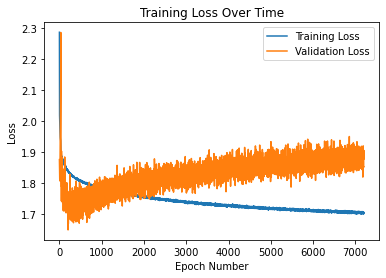

In [38]:
plot_training_history(history)

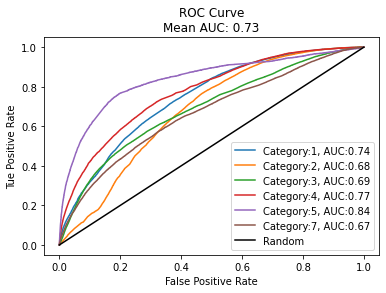

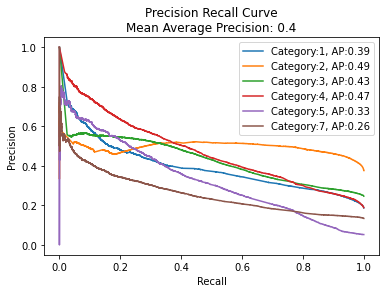

In [39]:
pred_y = model.predict([train_X_orders, train_X_order_month, train_X_sessions])
evaluate_model_performance(pred_y, train_Y_order)

#### Test Performance

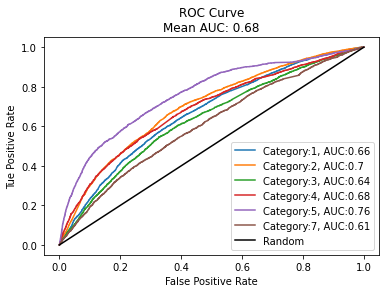

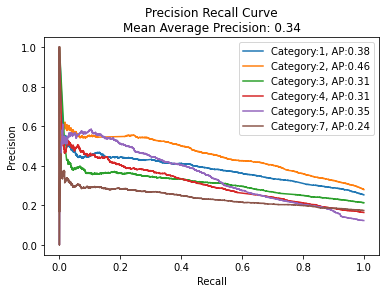

In [40]:
pred_y = model.predict([test_X_orders, test_X_order_month, test_X_sessions])
evaluate_model_performance(pred_y, test_Y_order)

# Junk Below

In [ ]:
def fully_connected_network(
    X, layrs, activation, last_activation, dropout, regularizer
):
    input_layer = x = keras.Input(shape=(X.shape[1],), name='Order_History')
    
    i = 0
    for layer in layrs:
        i+=1
        x = layers.BatchNormalization(name=f'BatchNorm{i}')(x)
        x = layers.Dense(layer, activation=activation, name=f'Dense{i}')(x)
        x = layers.Dropout(dropout, name=f'Dropout{i}')(x)
    
    outputs = layers.Dense(6, activation=last_activation)(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name="Fully_Connected_Model")
    return model

In [ ]:
test_Y_order

# Junk Below

#### Read in Data
 - normalize between 0 and 1

In [ ]:
train_x = pd.read_pickle('data/train_x_order_only.pkl').values
train_y = pd.read_pickle('data/train_y_order_only.pkl').values

In [ ]:
test_x = pd.read_pickle('data/test_x_order_only.pkl').values
test_y = pd.read_pickle('data/test_y_order_only.pkl').values

In [ ]:
train_x.shape

In [ ]:
train_y.shape

# Random Numbers

In [ ]:
pred_y = np.random.uniform(0,1,test_y.shape)

In [ ]:
evaluate_model_performance(pred_y, test_y)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Select Important Features

In [ ]:
# Create Random Variables
random_vars = np.random.uniform(0,1,(135889,3))
train_x_random = np.hstack((train_x, random_vars))

In [ ]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=10)
RF_Model.fit(train_x_random, train_y)

In [ ]:
from performance_evaluation import model_vars

In [ ]:
model_vars_random = np.array(model_vars+['rand1', 'rand2', 'rand3'])

In [ ]:
variable_importance = pd.DataFrame(
    [RF_Model.feature_importances_], columns=model_vars_random
)

#### Grab Variables with importance > Max of the 3 random variables

In [ ]:
average_random_importance = variable_importance[['rand1', 'rand2', 'rand3']].T.max()[0]

In [ ]:
significant_var_mask = np.argwhere(RF_Model.feature_importances_ > average_random_importance)

In [ ]:
sig_var_names = model_vars_random[significant_var_mask][:,0]
sig_var_importance = RF_Model.feature_importances_[significant_var_mask][:,0]
sig_var_df = pd.DataFrame([sig_var_importance], columns = sig_var_names)
sig_var_df = sig_var_df.T.sort_values(0,ascending=False)

In [ ]:
plt.rcParams["figure.figsize"] = (5,10)

In [ ]:
plt.barh(sig_var_df.index, sig_var_df[0])
plt.title('Significant Variables in Model')
plt.show()

## Train Model on Significant Features

In [ ]:
sig_train_x = train_x[:,significant_var_mask[:,0]]

In [ ]:
# Train Model
RF_Model = RandomForestClassifier(n_jobs=-1, max_depth=20)
RF_Model.fit(sig_train_x, train_y)

In [ ]:
sig_test_x = test_x[:,significant_var_mask[:,0]]

In [ ]:
train_pred_y = np.array(RF_Model.predict_proba(sig_train_x))
train_pred_y = train_pred_y[:,:,1].T

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

In [ ]:
evaluate_model_performance(train_pred_y, train_y)

In [ ]:
test_pred_y = np.array(RF_Model.predict_proba(sig_test_x))
test_pred_y = test_pred_y[:,:,1].T

In [ ]:
evaluate_model_performance(test_pred_y, test_y)

# Deep Fully Connected NN

#### Normalize for Faster Training

In [ ]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

In [ ]:
range_for_x_cols = np.amax(train_x, axis=0) - np.amin(train_x, axis=0)
range_for_x_cols = np.array([zero_to_ones(x) for x in range_for_x_cols])

In [ ]:
norm_train_x = train_x/range_for_x_cols
norm_test_x = test_x/range_for_x_cols

# Build Model

In [ ]:
def fully_connected_network(
    X, layrs, activation, last_activation, dropout, regularizer
):
    input_layer = x = keras.Input(shape=(X.shape[1],), name='Order_History')
    
    i = 0
    for layer in layrs:
        i+=1
        x = layers.BatchNormalization(name=f'BatchNorm{i}')(x)
        x = layers.Dense(layer, activation=activation, name=f'Dense{i}')(x)
        x = layers.Dropout(dropout, name=f'Dropout{i}')(x)
    
    outputs = layers.Dense(6, activation=last_activation)(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name="Fully_Connected_Model")
    return model

In [ ]:
fc_layers = [800, 400, 400, 200, 200, 100, 50, 10]

In [ ]:
model = fully_connected_network(norm_train_x, fc_layers, 'elu', 'sigmoid', .8, 1)

In [ ]:
model.summary()

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(norm_train_x, train_y, batch_size=1000, epochs=20000, validation_split=0.2)

In [ ]:
plot_training_history(history)

#### Training Performance

In [ ]:
pred_y = model.predict(norm_train_x)
evaluate_model_performance(pred_y, train_y)

#### Test Performance

In [ ]:
pred_y = model.predict(norm_test_x)
evaluate_model_performance(pred_y, test_y)